# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.io.formats.style import Styler
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline

import sys
import os
from random import choice
import gc

import warnings; warnings.filterwarnings('ignore')

from cycler import cycler
from colorama import Style, Fore
from IPython.display import display

import cv2

sys.path.append('..')
from config import CFG
CFG = CFG()
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', CFG.NCOLS)
pd.set_option('display.max_rows', CFG.NROWS)

# Visuals Configurations

In [2]:
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
mgt = Style.BRIGHT + Fore.MAGENTA
grn = Style.BRIGHT + Fore.GREEN
gld = Style.BRIGHT + Fore.YELLOW
res = Style.RESET_ALL

palette = ['#3c3744', '#048BA8', '#EE6352', '#E1BB80', '#78BC61']
grey_palette = ['#8e8e93', '#636366', '#48484a', '#3a3a3c', '#2c2c2e', '#1c1c27']
bg_color = '#F6F5F5'
white_color = '#d1d1d6'

custom_params = {
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.left': False,
    'grid.alpha':0.2,
    'figure.figsize': (16, 6),
    'axes.titlesize': 'large',
    'axes.labelsize': 'large',
    'ytick.labelsize': 'medium',
    'xtick.labelsize': 'medium',
    'legend.fontsize': 'large',
    'lines.linewidth': 1,
    'axes.prop_cycle': cycler('color',palette),
    'figure.facecolor': bg_color,
    'figure.edgecolor': bg_color,
    'axes.facecolor': bg_color,
    'text.color':grey_palette[1],
    'axes.labelcolor':grey_palette[1],
    'axes.edgecolor':grey_palette[1],
    'xtick.color':grey_palette[1],
    'ytick.color':grey_palette[1],
    'figure.dpi':150,
}
sns.set_theme(
    style='whitegrid',
    palette=sns.color_palette(palette),
    rc=custom_params)

display(sns.color_palette(palette))
display(sns.color_palette(grey_palette))
display(sns.color_palette([bg_color, white_color]))

[(0.23529411764705882, 0.21568627450980393, 0.26666666666666666),
 (0.01568627450980392, 0.5450980392156862, 0.6588235294117647),
 (0.9333333333333333, 0.38823529411764707, 0.3215686274509804),
 (0.8823529411764706, 0.7333333333333333, 0.5019607843137255),
 (0.47058823529411764, 0.7372549019607844, 0.3803921568627451)]

[(0.5568627450980392, 0.5568627450980392, 0.5764705882352941),
 (0.38823529411764707, 0.38823529411764707, 0.4),
 (0.2823529411764706, 0.2823529411764706, 0.2901960784313726),
 (0.22745098039215686, 0.22745098039215686, 0.23529411764705882),
 (0.17254901960784313, 0.17254901960784313, 0.1803921568627451),
 (0.10980392156862745, 0.10980392156862745, 0.15294117647058825)]

[(0.9647058823529412, 0.9607843137254902, 0.9607843137254902),
 (0.8196078431372549, 0.8196078431372549, 0.8392156862745098)]

In [116]:
# Dataframe visual helper functions

def magnify(is_test: bool = False):
    """
    Magnifies the cell when the cursor is hovering above it
    """
    base_color = '#457ea5'
    if is_test:
            highlight_target_row = []
    else:
            highlight_target_row = [
                dict(
                    selector='tr:last-child',
                    props=[('background-color', f'{base_color}20')],
                )
            ]
            
    return [dict(selector="th",
                    props=[("font-size", "11pt"),
                        ('background-color', f'{base_color}'),
                        ('color', 'white'),
                        ('font-weight', 'bold'),
                        ('border-bottom', '0.1px solid white'),
                        ('border-left', '0.1px solid white'),
                        ('text-align', 'right')]),

            dict(selector='th.blank.level0', 
                props=[('font-weight', 'bold'),
                        ('border-left', '1.7px solid white'),
                        ('background-color', 'white')]),

            dict(selector="td",
                    props=[('padding', "0.5em 1em"),
                        ('text-align', 'right')]),

            dict(selector="th:hover",
                    props=[("font-size", "14pt")]),

            dict(selector="tr:hover td:hover",
                    props=[('max-width', '250px'),
                        ('font-size', '14pt'),
                        ('color', f'{base_color}'),
                        ('font-weight', 'bold'),
                        ('background-color', 'white'),
                        ('border', f'1px dashed {base_color}')]),

                dict(selector="caption",
                    props=[(('caption-side', 'bottom'))])] + highlight_target_row

def stylize_describe(df: pd.DataFrame, dataset_name: str = 'train', is_test: bool = False) -> Styler:
    """
    Applies .describe() method to the df and wraps it into the Styler.
    """
    
    s = df.describe().T
    # A formatting dictionary for controlling each column precision (.000 <-). 
    cols = s.index.tolist()
    nulls = df[cols].isnull().sum()

    s['NaN count'] = nulls
    
    di_frmt = {(i if i == 'count' else i):
              ('{:.0f}' if i == 'count' else '{:.3f}') for i in s.columns}
    
    s = s.style.set_table_styles(magnify(is_test))\
        .format(di_frmt)\
        .set_caption(f"The {dataset_name} dataset descriptive statistics (hover to magnify).")
    return s

def stylize_simple(df: pd.DataFrame, caption: str) -> Styler:
    """
    Wraps the min_max_count pivot_table into the Styler.
    """
    s = df
    s = s.style.set_table_styles(magnify(True)).set_caption(f"{caption}")
    return s

# Data Exploration

- tdcsfog:
  - "comprising data series collected in the lab, as subjects completed a FOG-provoking protocol"
- defog:
  - "comprising data series collected in the subject's home, as subjects completed a FOG-provoking protocol"
- notype
  - "Series in the notype folder are from the defog dataset but lack event-type annotations"
- unlabeled
  - "Folder containing the unannotated data series from the daily dataset, one series per subject. Forty-five of the subjects also have series in the defog dataset, some in the training split and some in the test split. Accelerometer data has units of g."

"Trials from the tdcsfog and defog datasets were videotaped and annotated by expert reviewers documented the freezing of gait episodes. That is, the start, end and type of each episode were marked by the experts. Series in the daily dataset are unannotated. You will be detecting FOG episodes for the tdcsfog and defog series. You may wish to apply unsupervised or semi-supervised methods to the series in the daily dataset to support your detection modelling."

See this page for more on these datasets as well as video examples of freezing of gait events: [additional data documentation](https://www.kaggle.com/competitions/tlvmc-parkinsons-freezing-gait-prediction/overview/additional-data-documentation)

## Train Data

In [4]:
print(
    f'\t{gld}Number of files in "train/defog"\t--> \t {red}{len(os.listdir(f"{CFG.TRAIN_PATH}/defog"))}{res}'
)
print(
    f'\t{gld}Number of files in "train/notype"\t--> \t {red}{len(os.listdir(f"{CFG.TRAIN_PATH}/notype"))}{res}'
)
print(
    f'\t{gld}Number of files in "train/tdcsfog"\t--> \t {red}{len(os.listdir(f"{CFG.TRAIN_PATH}/tdcsfog"))}{res}'
)

	Number of files in "train/defog"	--> 	 91
	Number of files in "train/notype"	--> 	 46
	Number of files in "train/tdcsfog"	--> 	 833


## Train tdcsfog

In [243]:
example = choice(os.listdir(f"{CFG.TRAIN_PATH}/tdcsfog"))
train_tdcsfog_example = pd.read_csv(f"{CFG.TRAIN_PATH}/tdcsfog/{example}")

print(f"\t{gld}Shape of tdcsfog example dataframe \t --> \t {red}{train_tdcsfog_example.shape}{res}")
display(stylize_simple(train_tdcsfog_example.head(5), "train tdcsfog example dataframe, top 5 rows (hover to magnify)"))
display(stylize_describe(train_tdcsfog_example, dataset_name='train tdcsfog example'))

	Shape of tdcsfog example dataframe 	 --> 	 (8257, 7)


,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking
0,0,-9.644904,-1.083469,-1.430885,0,0,0
1,1,-9.660868,-1.083327,-1.430798,0,0,0
2,2,-9.645237,-1.079101,-1.439959,0,0,0
3,3,-9.653951,-1.087864,-1.435426,0,0,0
4,4,-9.645148,-1.085822,-1.453713,0,0,0


,count,mean,std,min,25%,50%,75%,max,NaN count
Time,8257,4128.000,2383.735,0.000,2064.000,4128.000,6192.000,8256.000,0.000
AccV,8257,-9.495,1.181,-20.856,-9.868,-9.614,-8.957,-5.282,0.000
AccML,8257,-1.008,1.303,-7.708,-1.516,-1.221,-0.381,5.576,0.000
AccAP,8257,1.562,1.626,-12.366,0.463,2.012,2.649,7.908,0.000
StartHesitation,8257,0.014,0.116,0.000,0.000,0.000,0.000,1.000,0.000
Turn,8257,0.411,0.492,0.000,0.000,0.000,1.000,1.000,0.000
Walking,8257,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


### Time Series Plots

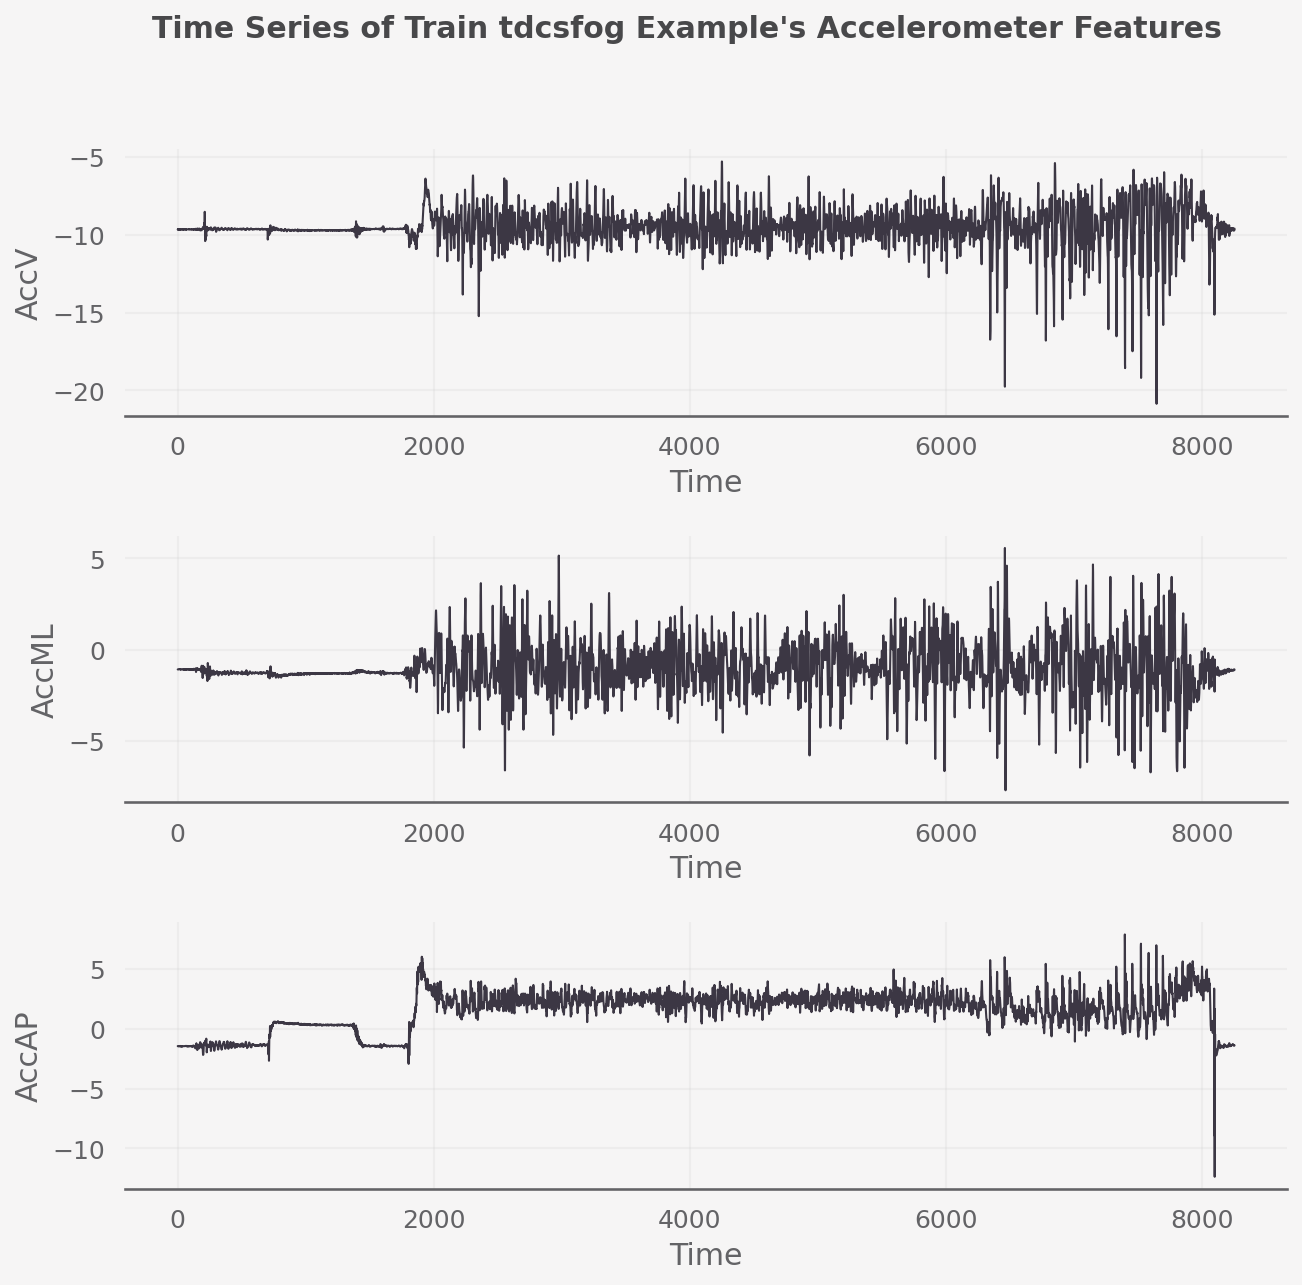

In [244]:
features = ['AccV','AccML','AccAP']

fig, axes = plt.subplots(3, 1, figsize=(10, 9))

for ax, col in zip(axes.ravel(), features):
    sns.lineplot(train_tdcsfog_example, x='Time', y=col, palette=grey_palette[3], ax=ax)

del train_tdcsfog_example

plt.subplots_adjust(hspace=0.45)
plt.suptitle("Time Series of Train tdcsfog Example's Accelerometer Features", ha='center',  fontweight='bold', color=grey_palette[2])
plt.show()

## Train defog

In [241]:
example = choice(os.listdir(f"{CFG.TRAIN_PATH}/defog"))
train_defog_example = pd.read_csv(f"{CFG.TRAIN_PATH}/defog/{example}")

print(f"\t{gld}Shape of defog example dataframe \t --> \t {red}{train_defog_example.shape}{res}")
display(stylize_simple(train_defog_example.head(5), "train defog example dataframe, top 5 rows (hover to magnify)"))
display(stylize_describe(train_defog_example, dataset_name='train defog example'))

	Shape of defog example dataframe 	 --> 	 (189216, 9)


,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Valid,Task
0,0,-0.921875,0.046875,-0.281043,0,0,0,False,False
1,1,-0.921875,0.046875,-0.265625,0,0,0,False,False
2,2,-0.921875,0.046875,-0.265625,0,0,0,False,False
3,3,-0.921875,0.031312,-0.265625,0,0,0,False,False
4,4,-0.921875,0.031250,-0.265625,0,0,0,False,False


,count,mean,std,min,25%,50%,75%,max,NaN count
Time,189216,94607.500,54622.099,0.000,47303.750,94607.500,141911.250,189215.000,0.000
AccV,189216,-0.913,0.056,-1.651,-0.945,-0.906,-0.891,-0.500,0.000
AccML,189216,0.026,0.062,-0.493,0.000,0.029,0.048,0.444,0.000
AccAP,189216,-0.240,0.192,-0.811,-0.360,-0.328,-0.234,0.297,0.000
StartHesitation,189216,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Turn,189216,0.116,0.321,0.000,0.000,0.000,0.000,1.000,0.000
Walking,189216,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


### Time Series Plots

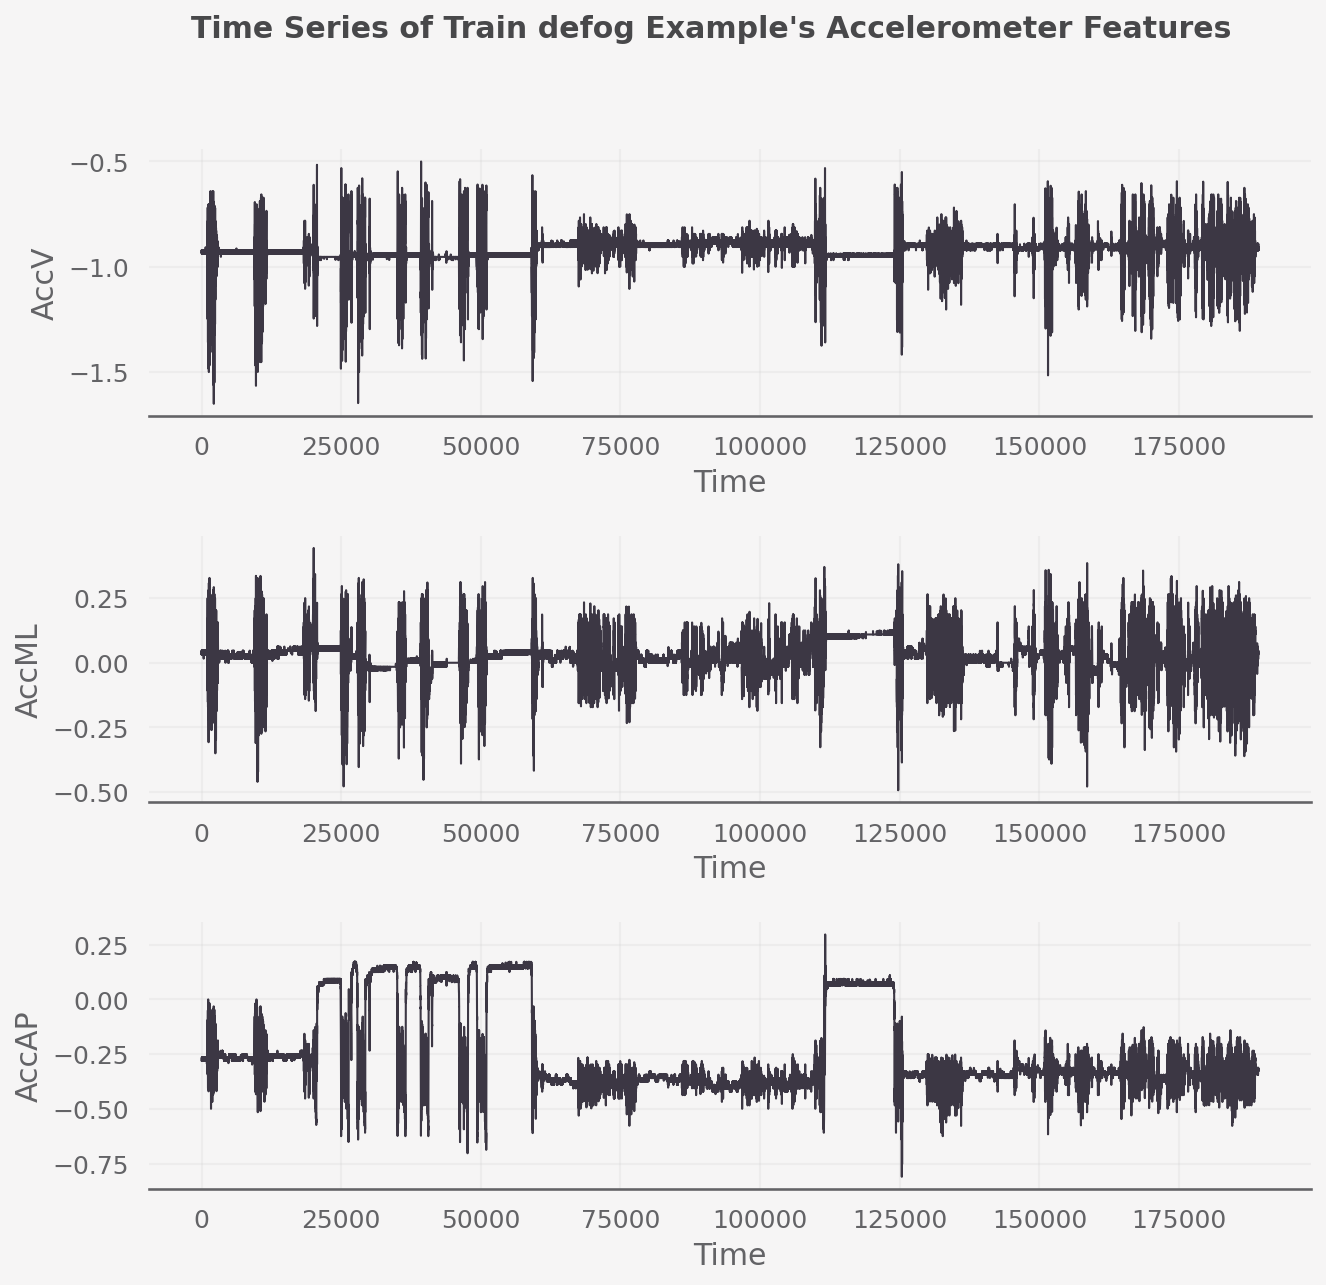

In [242]:
features = ['AccV','AccML','AccAP']

fig, axes = plt.subplots(3, 1, figsize=(10, 9))

for ax, col in zip(axes.ravel(), features):
    sns.lineplot(train_defog_example, x='Time', y=col, palette=grey_palette[3], ax=ax)

del train_defog_example

plt.subplots_adjust(hspace=0.45)
plt.suptitle("Time Series of Train defog Example's Accelerometer Features", ha='center',  fontweight='bold', color=grey_palette[2])
plt.show()

## Train notype

In [239]:
example = choice(os.listdir(f"{CFG.TRAIN_PATH}/notype"))
train_notype_example = pd.read_csv(f"{CFG.TRAIN_PATH}/notype/{example}")

print(f"\t{gld}Shape of notype example dataframe \t --> \t {red}{train_notype_example.shape}{res}")
display(stylize_simple(train_notype_example.head(5), "train notype example dataframe, top 5 rows (hover to magnify)"))
display(stylize_describe(train_notype_example, dataset_name='train notype example'))

	Shape of notype example dataframe 	 --> 	 (245616, 7)


,Time,AccV,AccML,AccAP,Event,Valid,Task
0,0,-0.897183,-0.052234,0.441415,0,False,False
1,1,-0.893823,-0.051813,0.437359,0,False,False
2,2,-0.892334,-0.054268,0.434094,0,False,False
3,3,-0.892334,-0.054788,0.434568,0,False,False
4,4,-0.892316,-0.056357,0.434220,0,False,False


,count,mean,std,min,25%,50%,75%,max,NaN count
Time,245616,122807.500,70903.376,0.000,61403.750,122807.500,184211.250,245615.000,0.000
AccV,245616,-0.954,0.083,-4.514,-0.984,-0.969,-0.907,-0.102,0.000
AccML,245616,-0.073,0.073,-2.503,-0.104,-0.062,-0.039,0.995,0.000
AccAP,245616,0.225,0.151,-2.044,0.143,0.184,0.253,0.768,0.000
Event,245616,0.000,0.009,0.000,0.000,0.000,0.000,1.000,0.000


### Time Series Plots

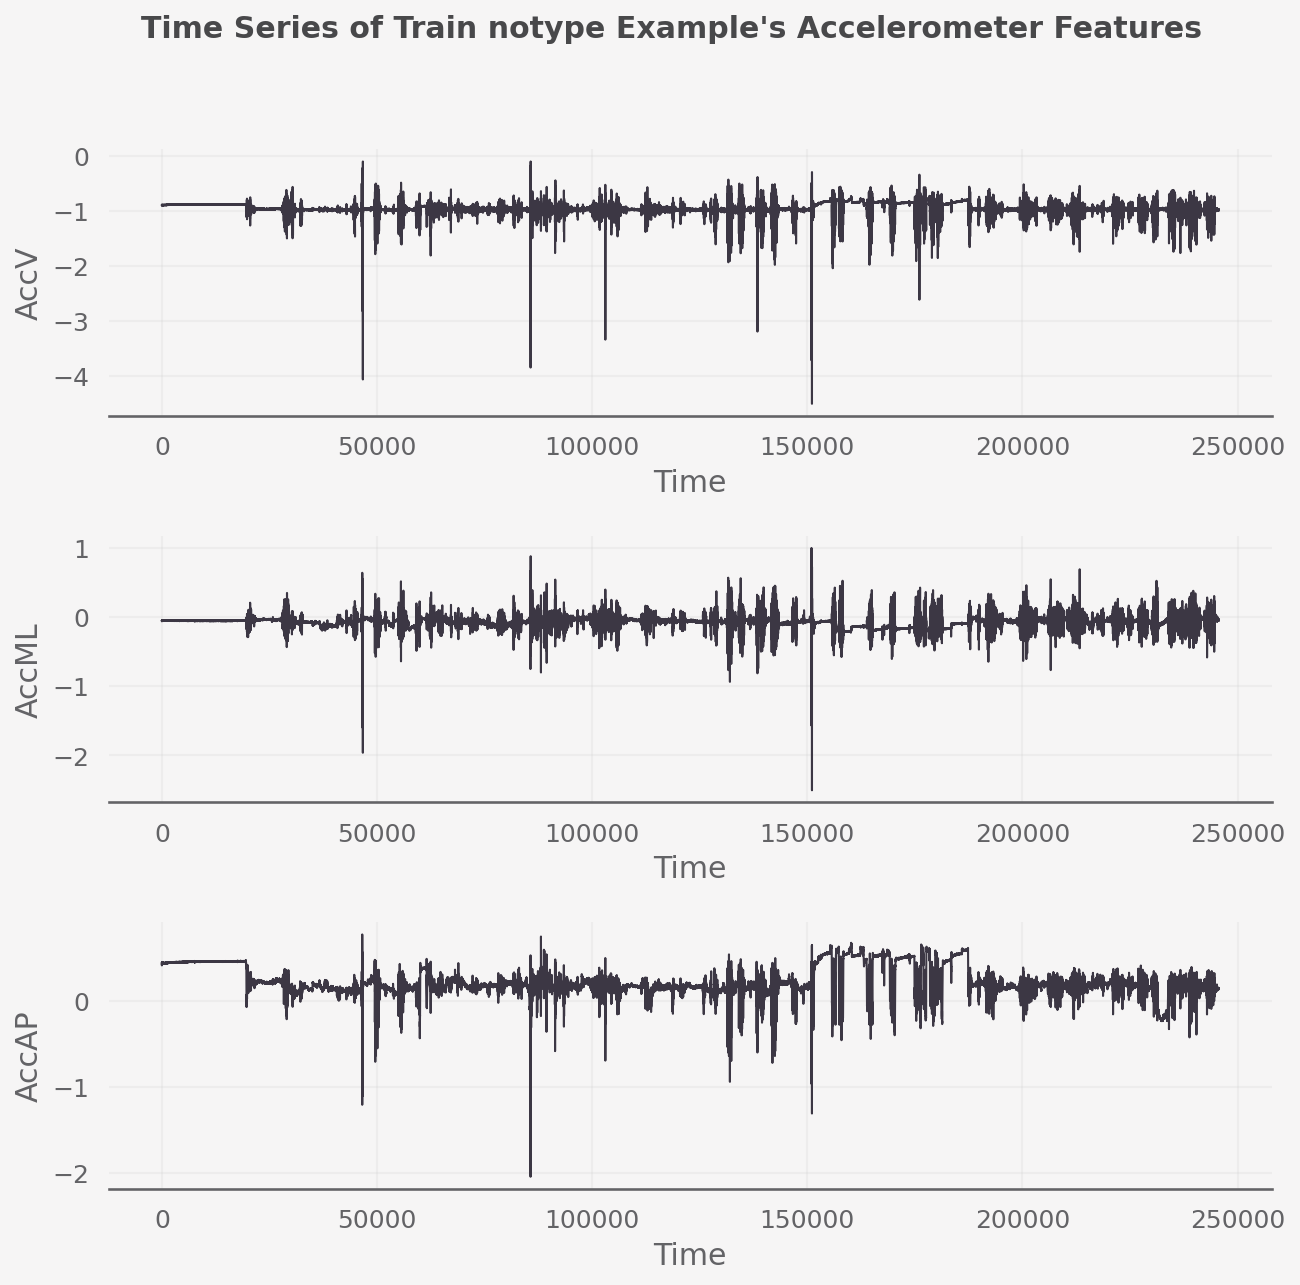

In [240]:
features = ['AccV','AccML','AccAP']

fig, axes = plt.subplots(3, 1, figsize=(10, 9))

for ax, col in zip(axes.ravel(), features):
    sns.lineplot(train_notype_example, x='Time', y=col, palette=grey_palette[3], ax=ax)

del train_notype_example

plt.subplots_adjust(hspace=0.45)
plt.suptitle("Time Series of Train notype Example's Accelerometer Features", ha='center',  fontweight='bold', color=grey_palette[2])
plt.show()

## Test Data Exploration

In [11]:
print(
    f'\t{gld}Number of files in "test/defog" \t--> \t {red}{len(os.listdir(f"{CFG.TEST_PATH}/defog"))}{res}'
)
print(
    f'\t{gld}Number of files in "test/tdcsfog"\t--> \t {red}{len(os.listdir(f"{CFG.TEST_PATH}/tdcsfog"))}{res}'
)

	Number of files in "test/defog" 	--> 	 1
	Number of files in "test/tdcsfog"	--> 	 1


In [245]:
test_tdcsfog = pd.read_csv(f'{CFG.TEST_PATH}/tdcsfog/003f117e14.csv')
print(f'\t{gld}Shape of test tdcsfog dataframe \t --> \t {red}{test_tdcsfog.shape}')
display(stylize_simple(test_tdcsfog.head(5), 'test tdcsfog dataframe, top 5 rows (hover to magnify)'))
display(stylize_describe(test_tdcsfog, dataset_name='test tdcsfog'))

	Shape of test tdcsfog dataframe 	 --> 	 (4682, 4)


,Time,AccV,AccML,AccAP
0,0,-9.533939,0.566322,-1.413525
1,1,-9.536140,0.564137,-1.440621
2,2,-9.529345,0.561765,-1.429332
3,3,-9.531239,0.564227,-1.415490
4,4,-9.540825,0.561854,-1.429471


,count,mean,std,min,25%,50%,75%,max,NaN count
Time,4682,2340.500,1351.721,0.000,1170.250,2340.500,3510.750,4681.000,0.000
AccV,4682,-9.151,1.384,-23.796,-9.538,-9.235,-8.470,-3.916,0.000
AccML,4682,0.754,1.102,-9.097,0.323,0.581,1.368,5.997,0.000
AccAP,4682,2.472,2.240,-7.353,1.967,3.138,3.820,10.281,0.000


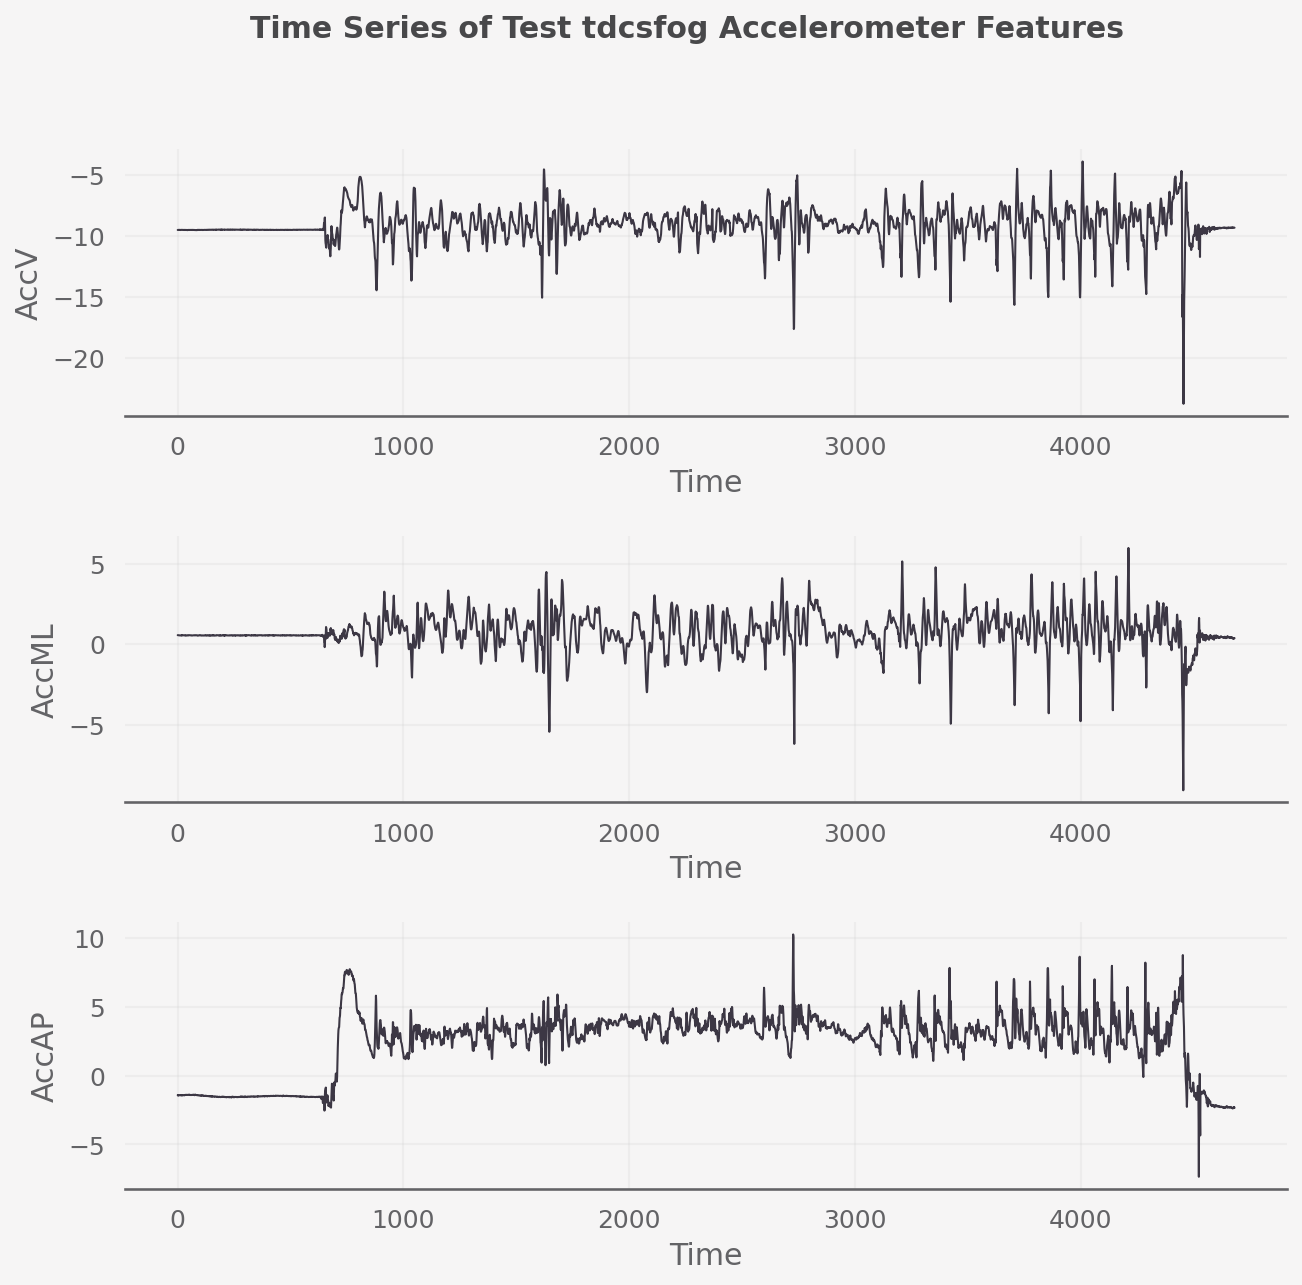

In [246]:
features = ['AccV','AccML','AccAP']

fig, axes = plt.subplots(3, 1, figsize=(10, 9))

for ax, col in zip(axes.ravel(), features):
    sns.lineplot(test_tdcsfog, x='Time', y=col, palette=grey_palette[3], ax=ax)

del test_tdcsfog

plt.subplots_adjust(hspace=0.45)
plt.suptitle("Time Series of Test tdcsfog Accelerometer Features", ha='center',  fontweight='bold', color=grey_palette[2])
plt.show()

## Test defog

In [233]:
test_defog = pd.read_csv(f'{CFG.TEST_PATH}/defog/02ab235146.csv')
print(f'\t{gld}Shape of test defog dataframe \t --> \t {red}{test_defog.shape}')
display(stylize_simple(test_defog.head(5), 'test defog dataframe, top 5 rows (hover to magnify)'))
display(stylize_describe(test_defog, dataset_name='test defog'))

	Shape of test defog dataframe 	 --> 	 (281688, 4)


,Time,AccV,AccML,AccAP
0,0,-0.914652,-0.300851,0.298156
1,1,-0.914367,-0.301572,0.298325
2,2,-0.779540,-0.343197,0.275690
3,3,-0.993162,-0.270281,0.315775
4,4,-0.948767,-0.307849,0.297191


,count,mean,std,min,25%,50%,75%,max,NaN count
Time,281688,140843.500,81316.466,0.000,70421.750,140843.500,211265.250,281687.000,0.000
AccV,281688,-0.942,0.072,-2.417,-0.982,-0.953,-0.899,0.537,0.000
AccML,281688,-0.040,0.146,-1.084,-0.208,0.005,0.069,0.739,0.000
AccAP,281688,-0.018,0.272,-1.090,-0.219,-0.088,0.243,1.037,0.000


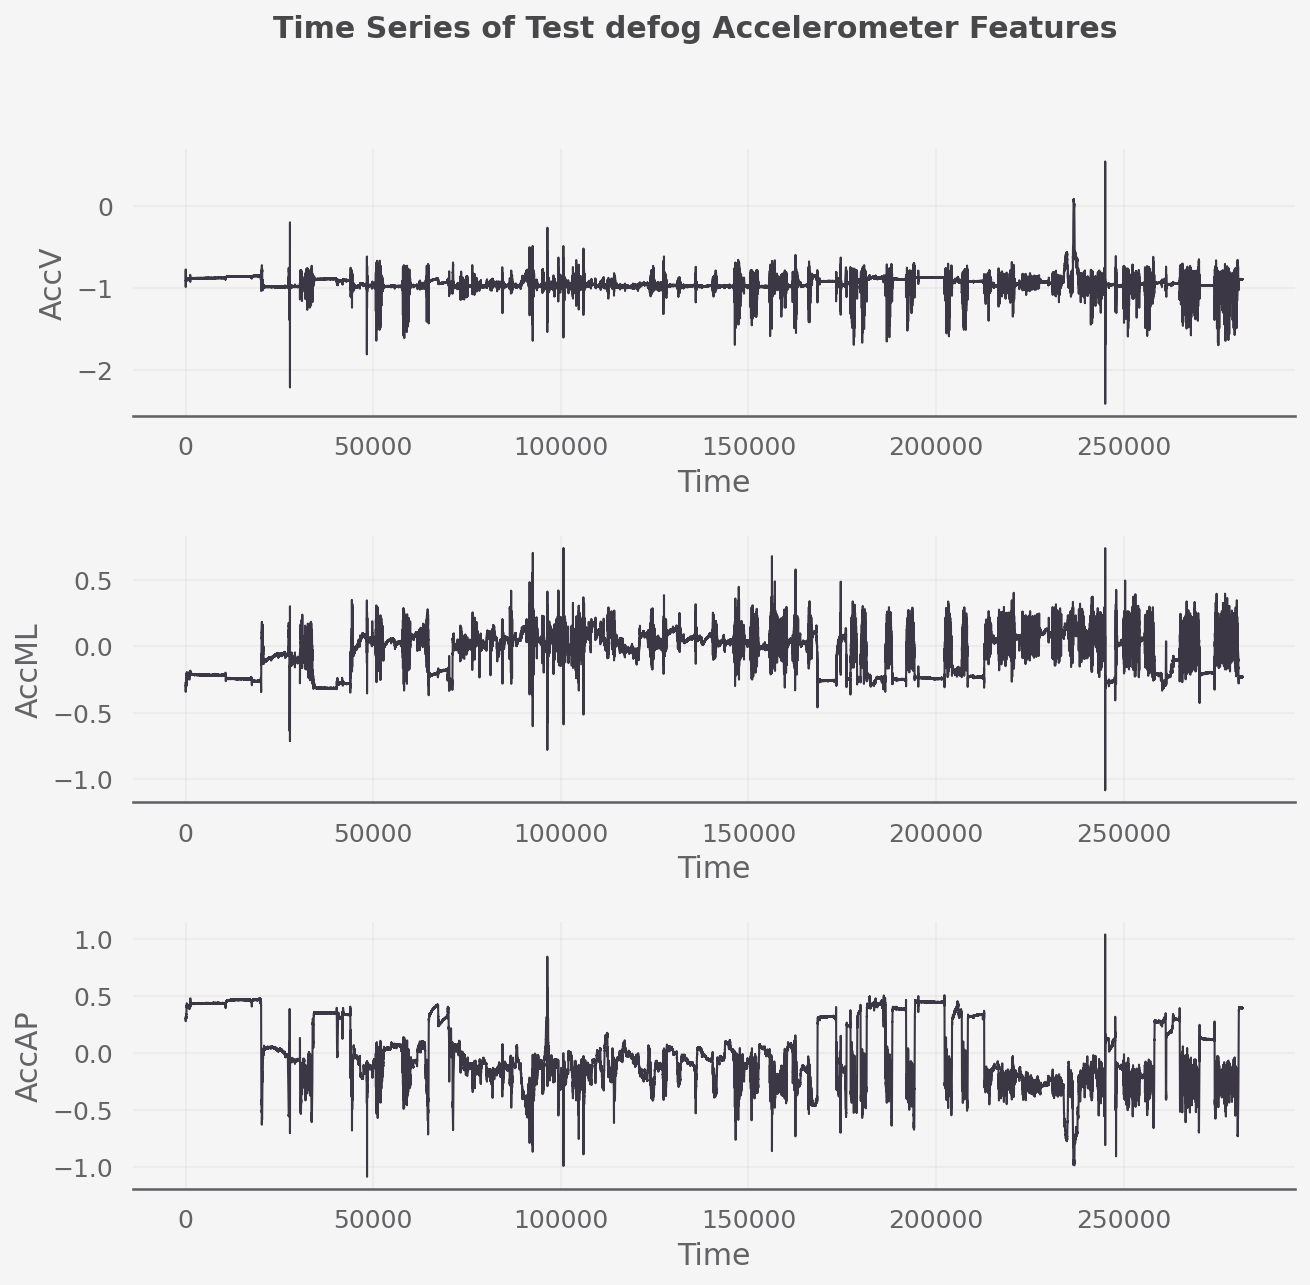

In [234]:
features = ['AccV','AccML','AccAP']

fig, axes = plt.subplots(3, 1, figsize=(10, 9))

for ax, col in zip(axes.ravel(), features):
    sns.lineplot(test_defog, x='Time', y=col, palette=grey_palette[3], ax=ax)

del test_defog

plt.subplots_adjust(hspace=0.45)
plt.suptitle("Time Series of Test defog Accelerometer Features", ha='center',  fontweight='bold', color=grey_palette[2])
plt.show()

## Unlabeled Data Exploration

In [16]:
print(
    f'\t{gld}Number of files in "unlabeled"   \t--> \t {red}{len(os.listdir(f"{CFG.UNLABELED_PATH}"))}{res}'
)
example = choice(os.listdir(f"{CFG.UNLABELED_PATH}"))
unlabeled_example = pd.read_parquet(f'{CFG.UNLABELED_PATH}/{example}')
print(f'\t{gld}Shape of unlabeled example\t\t --> \t {red}{unlabeled_example.shape}{res}')
display(stylize_simple(unlabeled_example.head(5), 'unlabeled example top 5 rows (hover to magnify)'))
display(stylize_describe(unlabeled_example, dataset_name='unlabeled example'))

	Number of files in "unlabeled"   	--> 	 65
	Shape of unlabeled example		 --> 	 (60479670, 4)


### Time Series Plots

NameError: name 'unlabeled_example' is not defined

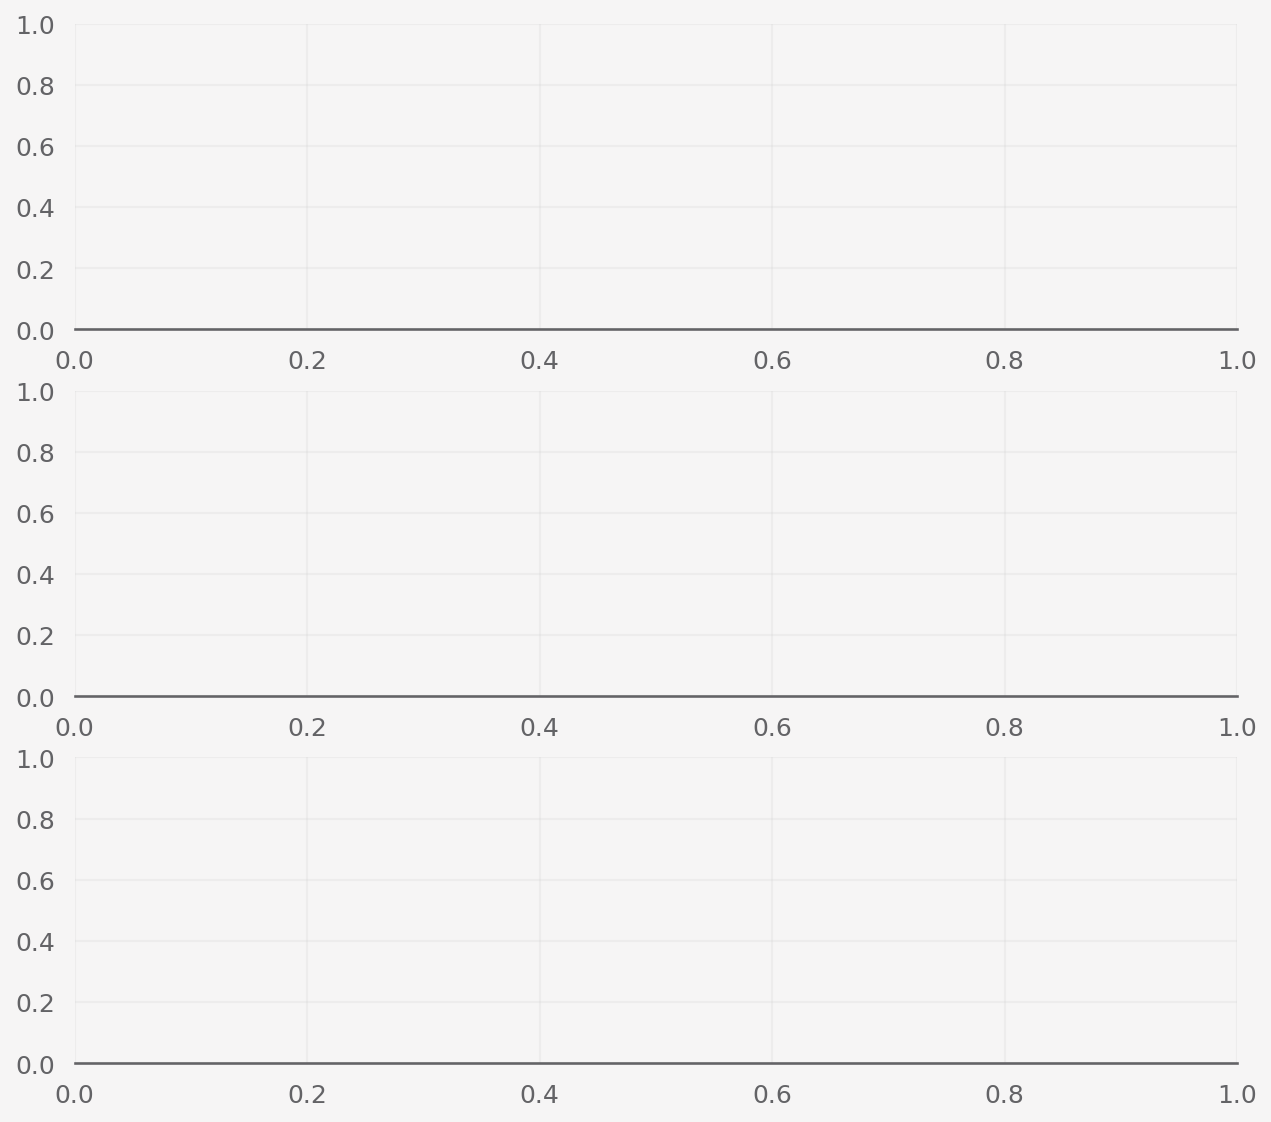

In [226]:
# Don't run this cell if you don't have at least 20Gb of RAM and 10mins to spare
features = ['AccV','AccML','AccAP']

fig, axes = plt.subplots(3, 1, figsize=(10, 9))

for ax, col in zip(axes.ravel(), features):
    sns.lineplot(unlabeled_example, x='Time', y=col, palette=grey_palette[3], ax=ax)
    gc.collect()

del unlabeled_example

plt.subplots_adjust(hspace=0.45)
plt.suptitle(f"Time Series of Unlabeled Example Accelerometer Features\n\n", ha='center',  fontweight='bold', color=grey_palette[2])
plt.show()

## Metadata Files

### tdcsfog Metadata

- Identifies each series in the tdcsfog dataset by a unique Subject, Visit, Test, Medication condition.
  - Visit Lab visits consist of a baseline assessment, two post-treatment assessments for different treatment stages, and one follow-up assessment.
  - Test Which of three test types was performed, with 3 the most challenging.
  - Medication Subjects may have been either off or on anti-parkinsonian medication during the recording.

In [20]:
tdcsfog_meta = pd.read_csv(f'{CFG.DATA_PATH}/tdcsfog_metadata.csv')

print(f'\t{gld}Shape of tdcsfog metadata \t --> \t {red}{tdcsfog_meta.shape}{res}')
display(stylize_simple(tdcsfog_meta.head(5), 'tdcsfog metadata, top 5 rows (hover to magnify)'))
display(stylize_describe(tdcsfog_meta, dataset_name='tdcsfog metadata'))

	Shape of tdcsfog metadata 	 --> 	 (833, 5)


,Id,Subject,Visit,Test,Medication
0,003f117e14,13abfd,3,2,on
1,009ee11563,d81e3a,4,2,on
2,011322847a,203e85,2,2,on
3,01d0fe7266,203e85,2,1,off
4,024418ba39,cecfb8,19,3,on


,count,mean,std,min,25%,50%,75%,max
Visit,833,6.461,6.172,2.000,2.000,4.000,5.000,20.000
Test,833,1.975,0.813,1.000,1.000,2.000,3.000,3.000


#### Unique Subjects

In [45]:
print(f'\t{gld}Number of unique subjects \t --> \t {red}{tdcsfog_meta["Subject"].nunique()}{res}')

subject_example = tdcsfog_meta.loc[tdcsfog_meta.sample(1).index, 'Subject'].values[0]
subject_example_df = tdcsfog_meta[tdcsfog_meta['Subject'] == subject_example]
display(stylize_simple(subject_example_df.head(10), 'top 10 rows of a singular subject ID (hover to magnify)'))

	Number of unique subjects 	 --> 	 62


,Id,Subject,Visit,Test,Medication
32,08fbe142f9,81c9ff,3,3,on
40,0b2b9bc455,81c9ff,3,1,on
43,0b73d30dee,81c9ff,3,2,off
71,12ff3f3f50,81c9ff,5,2,on
73,13d0015a77,81c9ff,4,1,on
171,3291d59f24,81c9ff,5,2,off
263,53e0167d78,81c9ff,4,3,off
315,6698568138,81c9ff,5,3,off
362,7912f48748,81c9ff,4,1,off
398,827fff250f,81c9ff,3,1,off


#### Bar Plots

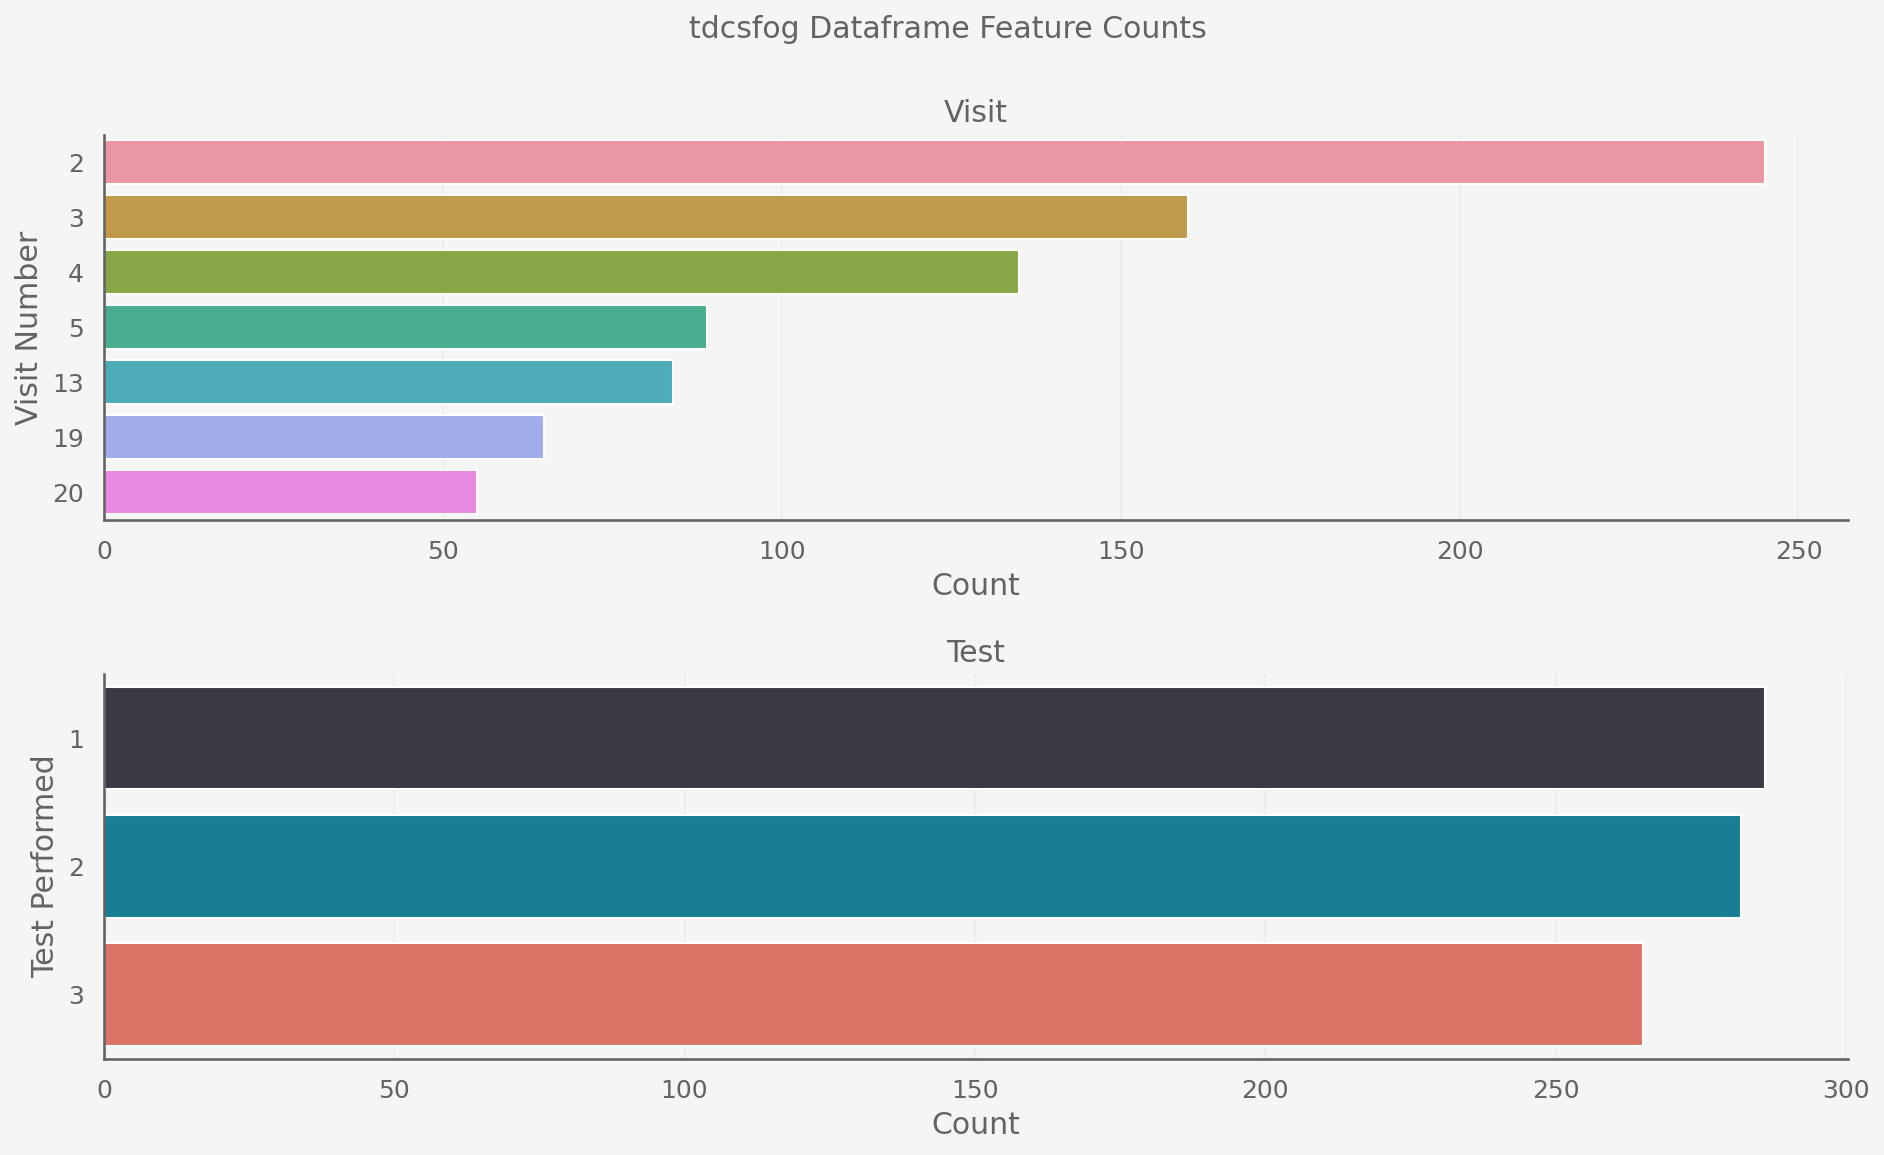

In [225]:
tdcsfog_meta_visit_counts = tdcsfog_meta['Visit'].value_counts()
tdcsfog_meta_test_counts = tdcsfog_meta['Test'].value_counts()

features = [tdcsfog_meta_visit_counts, tdcsfog_meta_test_counts]

fig, axes = plt.subplots(2, 1, figsize=(15, 8))

sns.barplot(y=tdcsfog_meta_visit_counts.index, x=tdcsfog_meta_visit_counts.values, ax=axes[0], orient='h')
axes[0].set_title('Visit')
axes[0].set_ylabel('Visit Number')

sns.barplot(y=tdcsfog_meta_test_counts.index, x=tdcsfog_meta_test_counts.values, ax=axes[1], orient='h')
axes[1].set_title('Test')
axes[1].set_ylabel('Test Performed')

for ax in axes:
    ax.spines['left'].set_visible(True)
    ax.set_xlabel('Count')

plt.suptitle('tdcsfog Dataframe Feature Counts')
plt.subplots_adjust(hspace=0.4)

In [89]:
def plot_count(df: pd.core.frame.DataFrame, column: str='Medication', title_name: str='Train') -> None:
    """
    Draws the pie and count plots for categorical variables.
    
    Args:
        title_name: 'Train' or 'Test' (default 'Train')
        
    Returns:
        subplots of size (len(col_list), 2)
    """
    f, ax = plt.subplots(1, 2, figsize=(10, 4))
    plt.subplots_adjust(wspace=0)
    
    s1 = df[column].value_counts()
    N = len(s1)

    outer_sizes = s1
    inner_sizes = s1/N

    outer_colors = [palette[0], palette[0], '#ff781f', '#ff9752', '#ff9752']
    inner_colors = [palette[1], palette[1], '#ffa66b']

    ax[0].pie(
        outer_sizes,colors=outer_colors, 
        labels=s1.index.tolist(), 
        startangle=90,frame=True, radius=1.3, 
        explode=([0.05]*(N-1) + [.3]),
        wedgeprops={ 'linewidth' : 1, 'edgecolor' : 'white'}, 
        textprops={'fontsize': 12, 'weight': 'bold'}
    )

    textprops = {
        'size':13, 
        'weight': 'bold', 
        'color':'white'
    }

    ax[0].pie(
        inner_sizes, colors=inner_colors,
        radius=1, startangle=90,
        autopct='%1.f%%',explode=([.1]*(N-1) + [.3]),
        pctdistance=0.8, textprops=textprops
    )

    center_circle = plt.Circle((0,0), .68, color='black', 
                               fc='white', linewidth=0)
    ax[0].add_artist(center_circle)

    x = s1
    y = [0, 1]
    sns.barplot(
        x=x, y=y, ax=ax[1],
        palette=palette[:2], orient='horizontal'
    )

    ax[1].tick_params(
        axis='x',         
        which='both',      
        bottom=False,      
        labelbottom=False
    )

    for i, v in enumerate(s1):
        ax[1].text(v, i+0.1, str(v), color='black', 
                     fontweight='bold', fontsize=12)

    plt.setp(ax[1].get_yticklabels(), fontweight="bold")
    plt.setp(ax[1].get_xticklabels(), fontweight="bold")
    ax[1].set_xlabel(column, fontweight="bold", color='black')
    ax[1].set_ylabel('count', fontweight="bold", color='black')

    f.suptitle(f'{title_name}', fontsize=20, fontweight='bold')
    plt.tight_layout()    
    plt.savefig(f'../data/plot_count_{title_name}.png')
    plt.show()

#### Medication Pie Chart

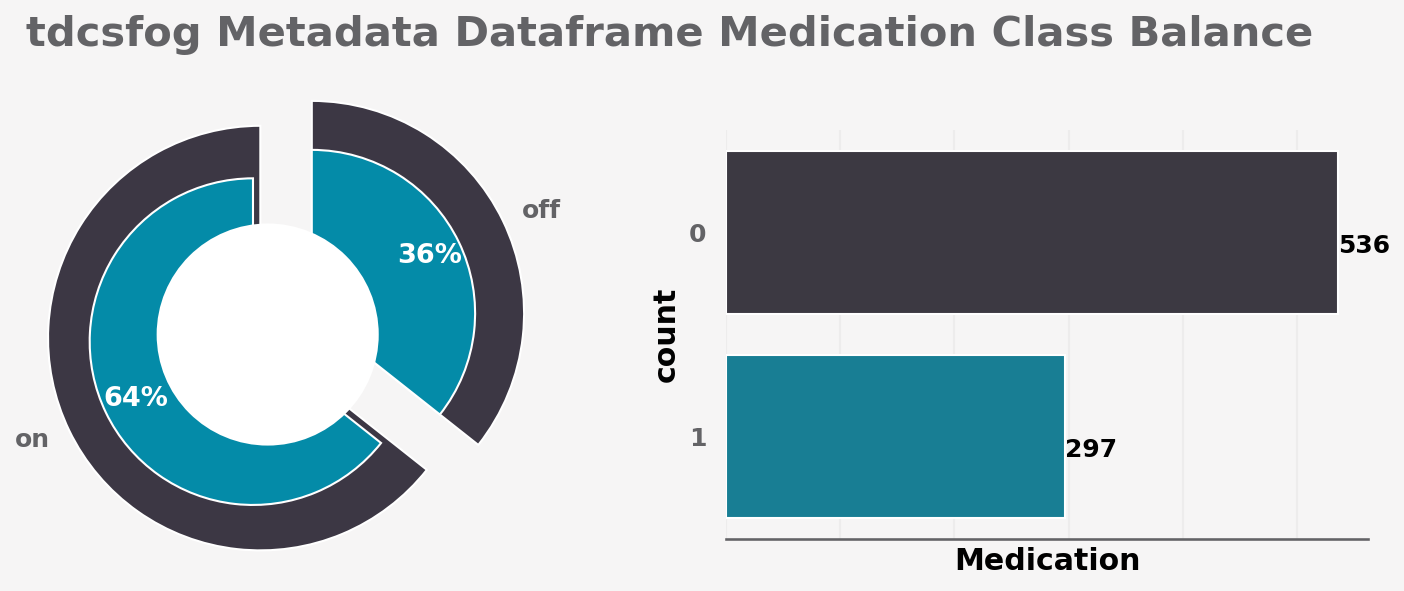

In [224]:
plot_count(tdcsfog_meta, 'Medication', 'tdcsfog Metadata Dataframe Medication Class Balance')

### defog Metadata

- Identifies each series in the defog dataset by a unique Subject, Visit, Medication condition.

In [87]:
defog_metadata = pd.read_csv(f'{CFG.DATA_PATH}/defog_metadata.csv')

print(f'\t{gld}Shape of defog metadata \t --> \t {red}{defog_metadata.shape}{res}')
display(stylize_simple(defog_metadata.head(5), 'defog metadata, top 5 rows (hover to magnify)'))
display(stylize_describe(defog_metadata, dataset_name='defog metadata'))

print(f'\t{gld}Number of unique subjects \t --> \t {red}{defog_metadata["Subject"].nunique()}{res}')

subject_example = defog_metadata.loc[defog_metadata.sample(1).index, 'Subject'].values[0]
subject_example_df = defog_metadata[defog_metadata['Subject'] == subject_example]
display(stylize_simple(subject_example_df.head(10), 'top 10 rows of a singular subject ID (hover to magnify)'))

	Shape of defog metadata 	 --> 	 (137, 4)


,Id,Subject,Visit,Medication
0,02ab235146,ab54e1,2,on
1,02ea782681,bf608b,2,on
2,06414383cf,c0b71e,2,off
3,092b4c1819,b6a627,1,off
4,0a900ed8a2,b7bd52,2,on


,count,mean,std,min,25%,50%,75%,max
Visit,137,1.489,0.502,1.000,1.000,1.000,2.000,2.000


	Number of unique subjects 	 --> 	 45


,Id,Subject,Visit,Medication
9,139f60d29b,49f526,1,off
109,be9d33541d,49f526,1,on


#### Pie Charts

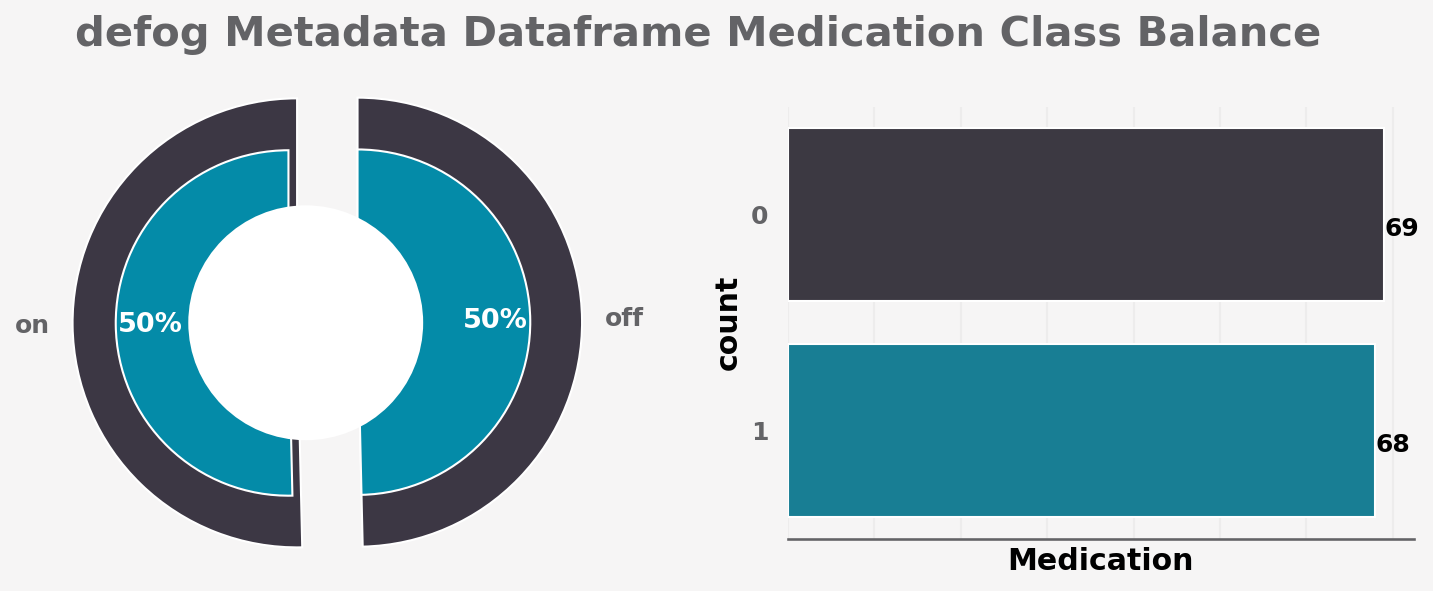

None

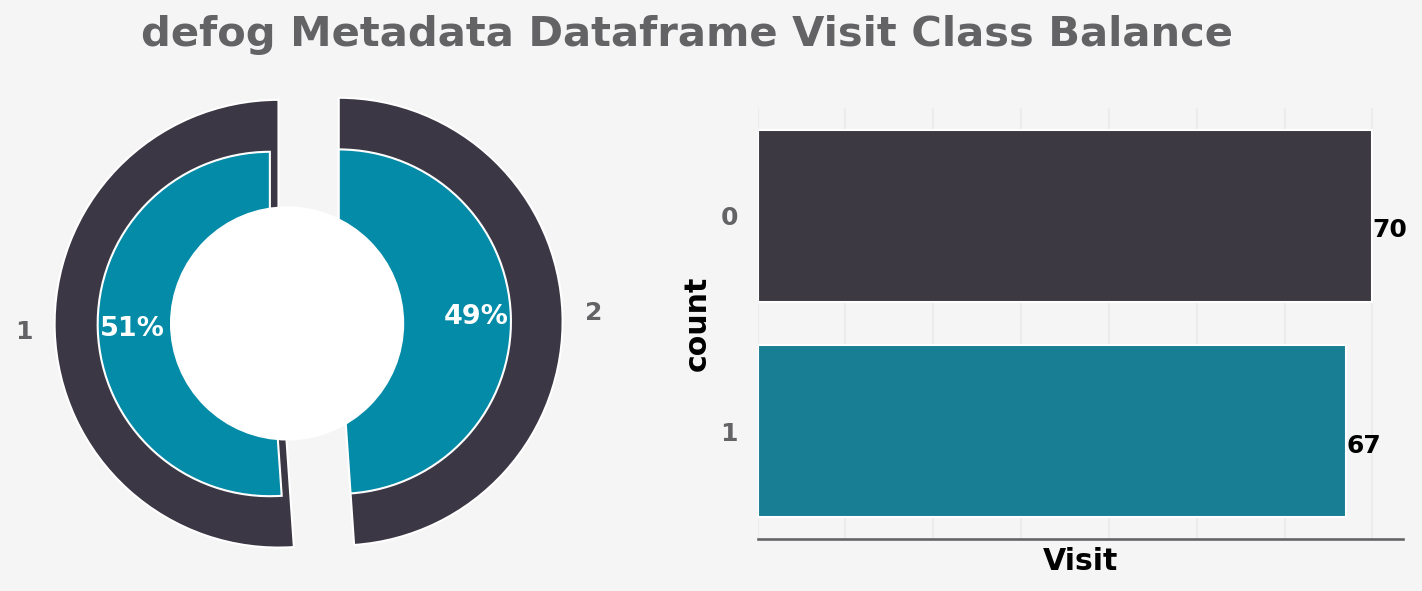

None

In [223]:
display(plot_count(defog_metadata, 'Medication', 'defog Metadata Dataframe Medication Class Balance'))
display(plot_count(defog_metadata, 'Visit', 'defog Metadata Dataframe Visit Class Balance'))

### Daily Metadata

- Each series in the daily dataset is identified by the Subject id. This file also contains the time of day the recording began.

In [93]:
daily_metadata = pd.read_csv(f'{CFG.DATA_PATH}/daily_metadata.csv')

print(f'\t{gld}Shape of daily metadata \t --> \t {red}{daily_metadata.shape}{res}')
display(stylize_simple(daily_metadata.head(5), 'daily metadata, top 5 rows (hover to magnify)'))
display(stylize_describe(daily_metadata, dataset_name='daily metadata'))

print(f'\t{gld}Number of unique subjects \t --> \t {red}{daily_metadata["Subject"].nunique()}{res}')

subject_example = daily_metadata.loc[daily_metadata.sample(1).index, 'Subject'].values[0]
subject_example_df = daily_metadata[daily_metadata['Subject'] == subject_example]
display(stylize_simple(subject_example_df.head(10), 'top 10 rows of a singular subject ID (hover to magnify)'))

	Shape of daily metadata 	 --> 	 (65, 4)


,Id,Subject,Visit,Beginning of recording [00:00-23:59]
0,00c4c9313d,3d8b73,1,10:19
1,07a96f89ec,a15b56,1,07:30
2,0d1bc672a8,21e523,2,08:30
3,0e333c9833,b068a2,1,11:30
4,164adaed7b,ffa798,1,13:00


,count,mean,std,min,25%,50%,75%,max
Visit,65,1.092,0.292,1.000,1.000,1.000,1.000,2.000


	Number of unique subjects 	 --> 	 65


,Id,Subject,Visit,Beginning of recording [00:00-23:59]
32,74f1e1e0ba,f80d3a,1,08:00


#### Pie Chart

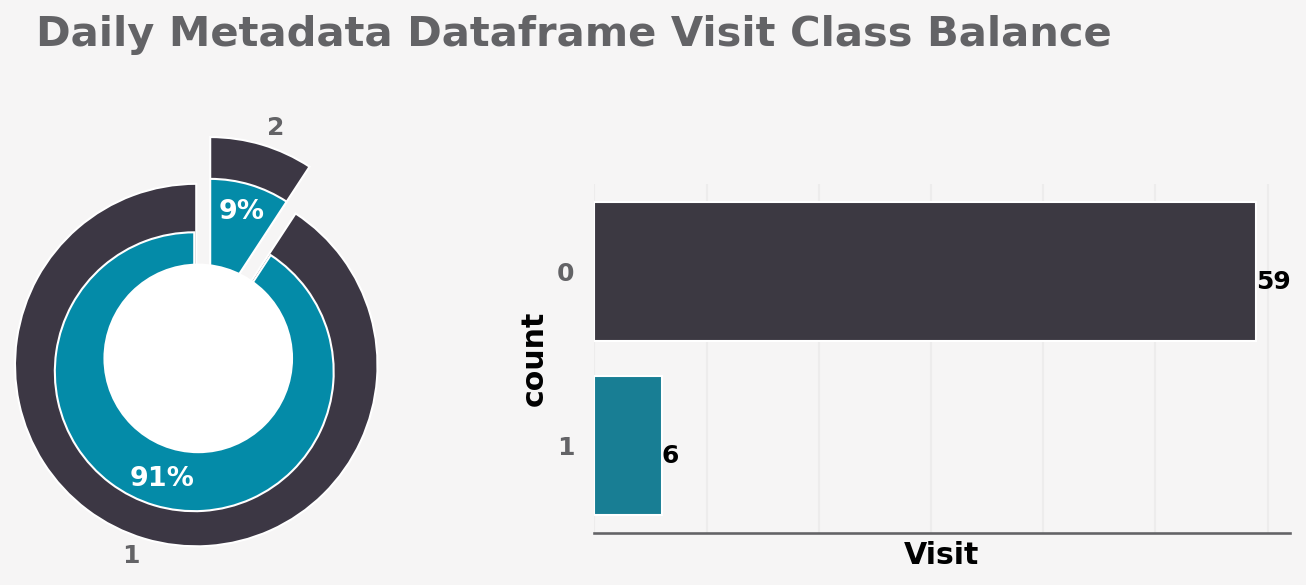

In [222]:
plot_count(daily_metadata, 'Visit', 'Daily Metadata Dataframe Visit Class Balance')

#### Bar Chart

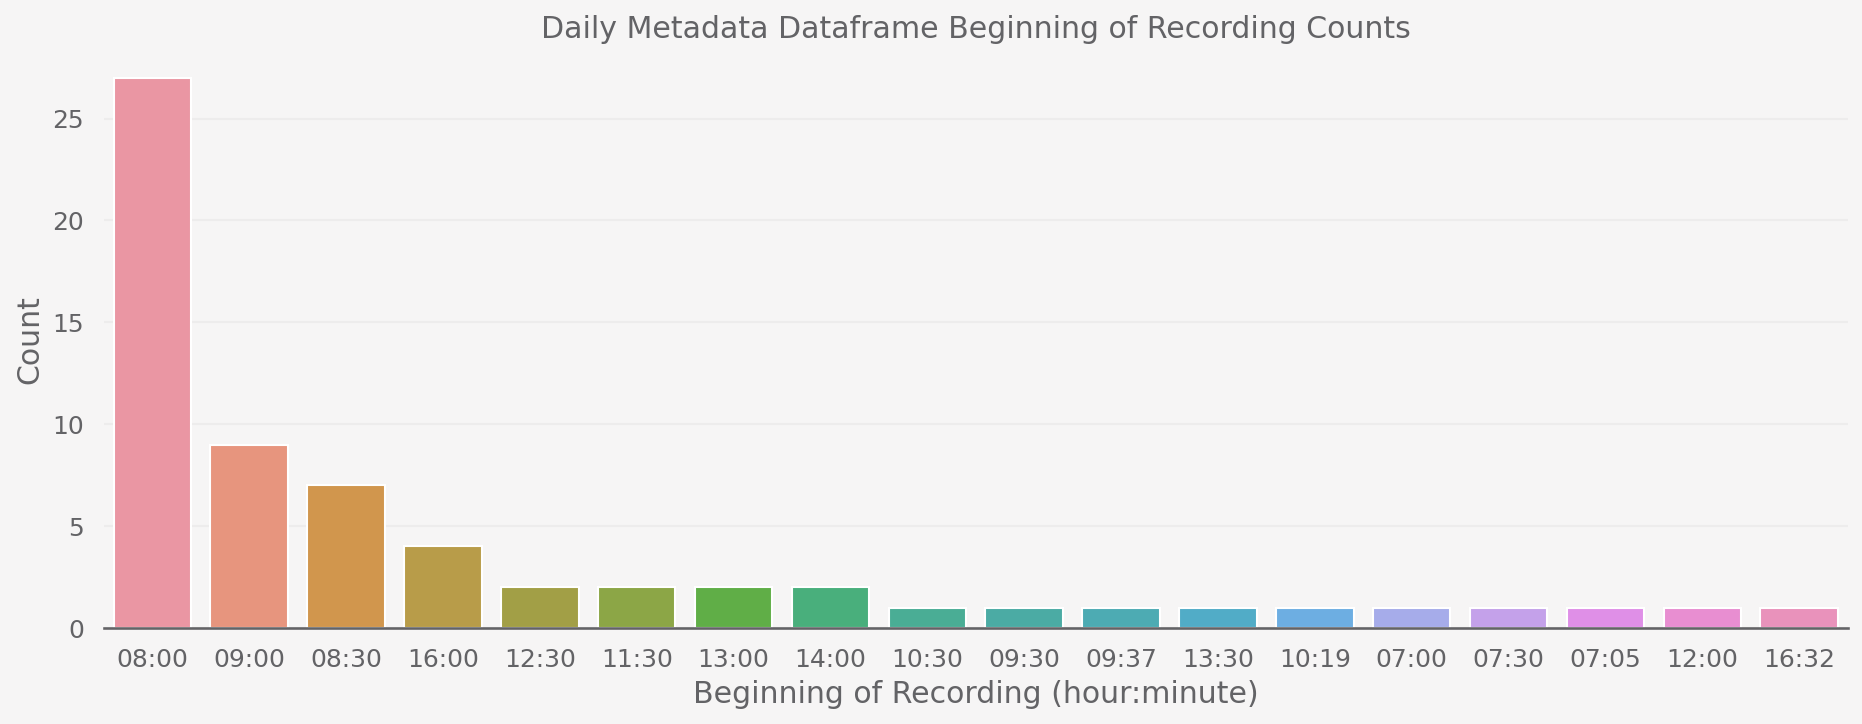

In [221]:
daily_BOR_counts = daily_metadata['Beginning of recording [00:00-23:59]'].value_counts()

plt.figure(figsize=(15, 5))

barplot = sns.barplot(x=daily_BOR_counts.index, y=daily_BOR_counts.values)

barplot.set_ylabel('Count')
barplot.set_xlabel('Beginning of Recording (hour:minute)')
barplot.set_title('Daily Metadata Dataframe Beginning of Recording Counts')

plt.show()

### Subjects

- Metadata for each Subject in the study, including their Age and Sex as well as:
  - Visit Only available for subjects in the daily and defog datasets.
  - YearsSinceDx Years since Parkinson's diagnosis.
  - UPDRSIIIOn/UPDRSIIIOff Unified Parkinson's Disease Rating Scale score during on/off medication respectively.
  - NFOGQ Self-report [FoG questionnaire score].(https://pubmed.ncbi.nlm.nih.gov/19660949/)

In [119]:
subjects = pd.read_csv(f'{CFG.DATA_PATH}/subjects.csv')

print(f'\t{gld}Shape of subjects \t --> \t {red}{subjects.shape}{res}')
display(stylize_simple(subjects.head(5), 'subjects, top 5 rows (hover to magnify)'))
display(stylize_describe(subjects, dataset_name='subjects'))

print(f'\t{gld}Number of unique subjects \t --> \t {red}{subjects["Subject"].nunique()}{res}')

subject_example = subjects.loc[subjects.sample(1).index, 'Subject'].values[0]
subject_example_df = subjects[subjects['Subject'] == subject_example]
display(stylize_simple(subject_example_df.head(10), 'top 10 rows of a singular subject ID (hover to magnify)'))

	Shape of subjects 	 --> 	 (173, 8)


,Subject,Visit,Age,Sex,YearsSinceDx,UPDRSIII_On,UPDRSIII_Off,NFOGQ
0,04fcdb,1.000000,63,M,3.000000,30.000000,nan,0
1,05595e,1.000000,56,M,8.000000,28.000000,nan,0
2,0967b2,1.000000,59,M,10.000000,38.000000,48.000000,19
3,0967b2,2.000000,59,M,10.000000,37.000000,44.000000,13
4,097078,nan,70,F,10.000000,27.000000,50.000000,20


,count,mean,std,min,25%,50%,75%,max,NaN count
Visit,111,1.369,0.485,1.000,1.000,1.000,2.000,2.000,62.000
Age,173,67.763,7.972,28.000,62.000,68.000,73.000,94.000,0.000
YearsSinceDx,173,10.384,6.289,0.420,6.000,9.000,15.000,30.000,0.000
UPDRSIII_On,172,34.273,12.733,5.000,25.000,35.000,42.250,79.000,1.000
UPDRSIII_Off,132,42.879,12.999,15.000,33.000,43.000,49.250,91.000,41.000
NFOGQ,173,17.121,7.575,0.000,15.000,19.000,22.000,29.000,0.000


	Number of unique subjects 	 --> 	 136


,Subject,Visit,Age,Sex,YearsSinceDx,UPDRSIII_On,UPDRSIII_Off,NFOGQ
147,e31e46,1.000000,66,M,10.000000,34.000000,43.000000,21
148,e31e46,2.000000,66,M,10.000000,26.000000,39.000000,16


#### Plots

##### Pie

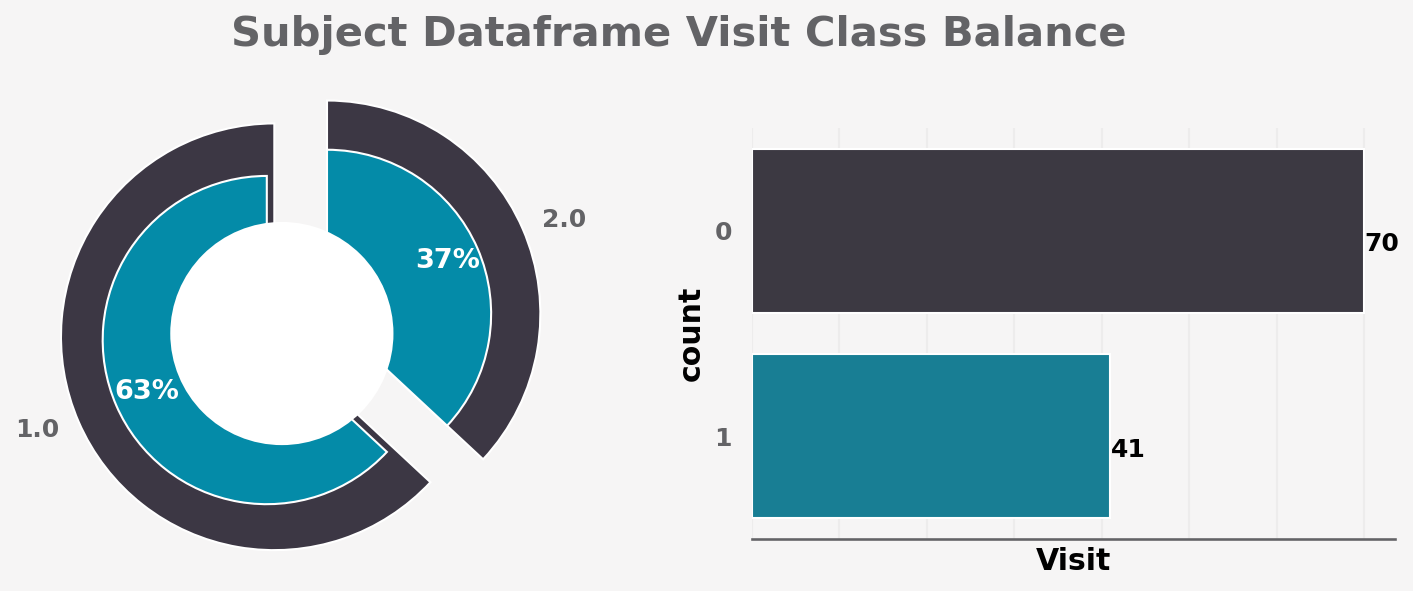

None

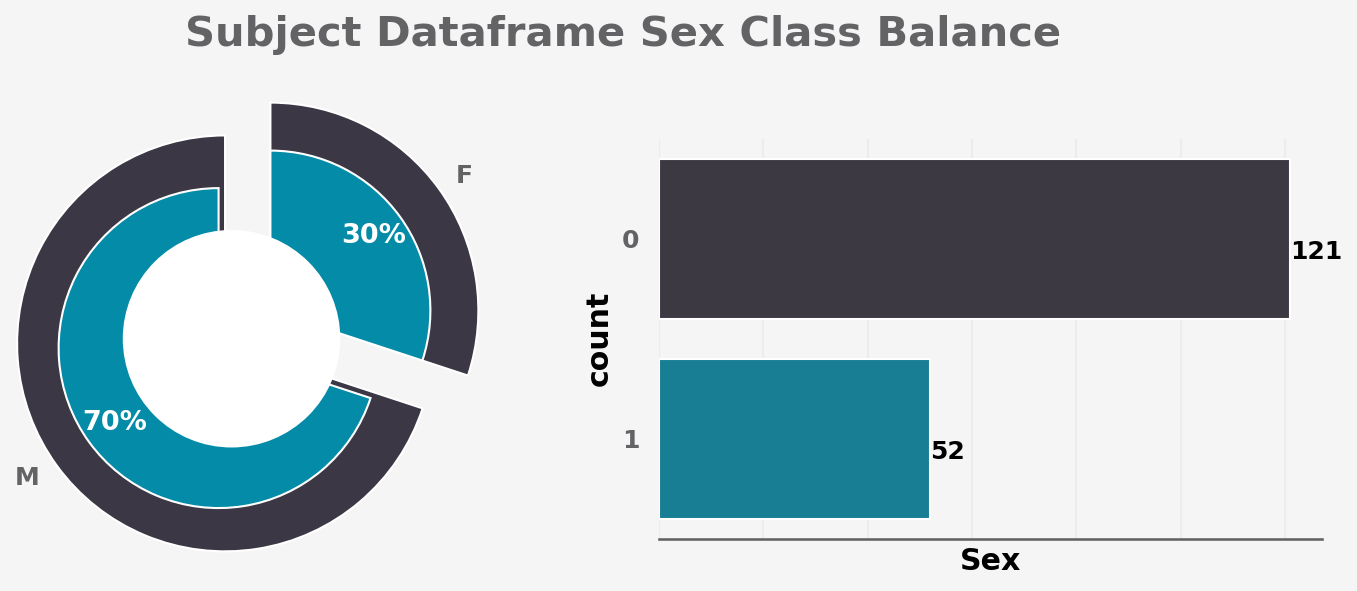

None

In [220]:
display(plot_count(subjects, 'Visit', 'Subject Dataframe Visit Class Balance'))
display(plot_count(subjects, 'Sex', 'Subject Dataframe Sex Class Balance'))

##### Histogram

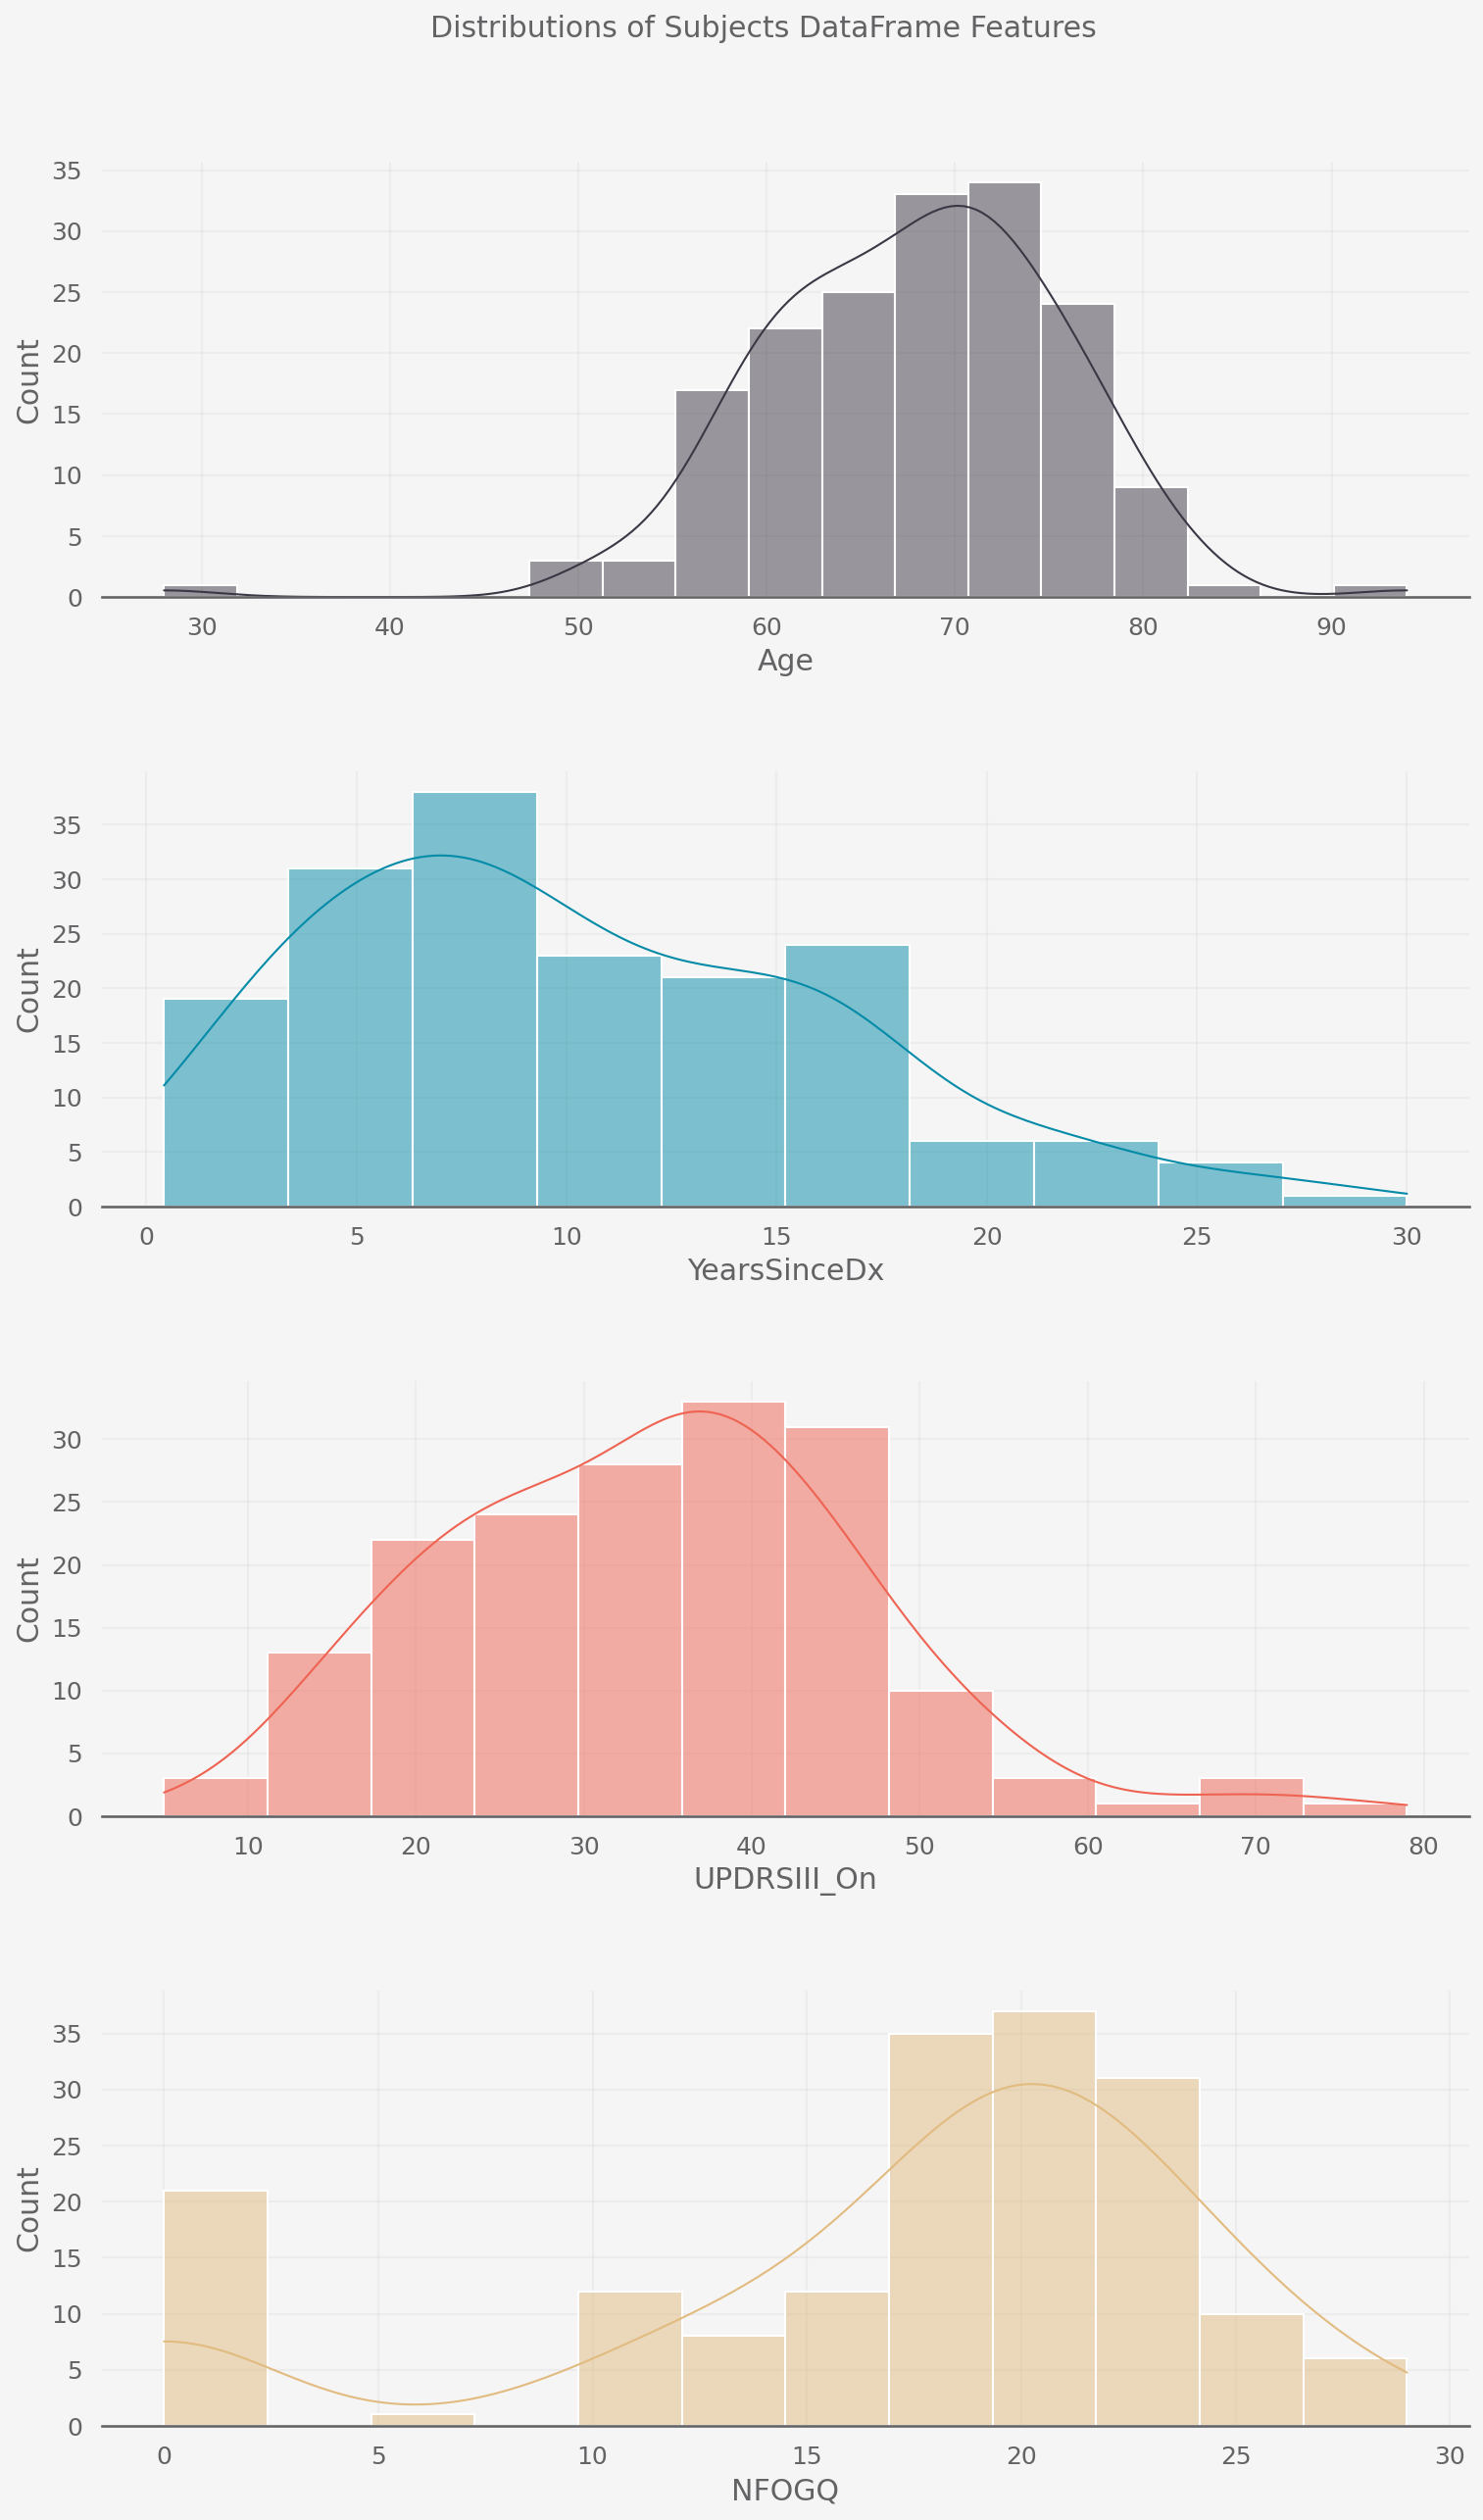

In [219]:
fig, axes = plt.subplots(4, 1, figsize=(12, 20))
features = ['Age', 'YearsSinceDx', 'UPDRSIII_On', 'NFOGQ']

for idx, (ax, col) in enumerate(zip(axes.ravel(), features)):
    sns.histplot(subjects, x=col, ax=ax, kde=True, color=palette[idx])

plt.subplots_adjust(hspace=0.4)
plt.suptitle('Distributions of Subjects DataFrame Features', y=.93)
plt.show()

##### Correlation Matrix

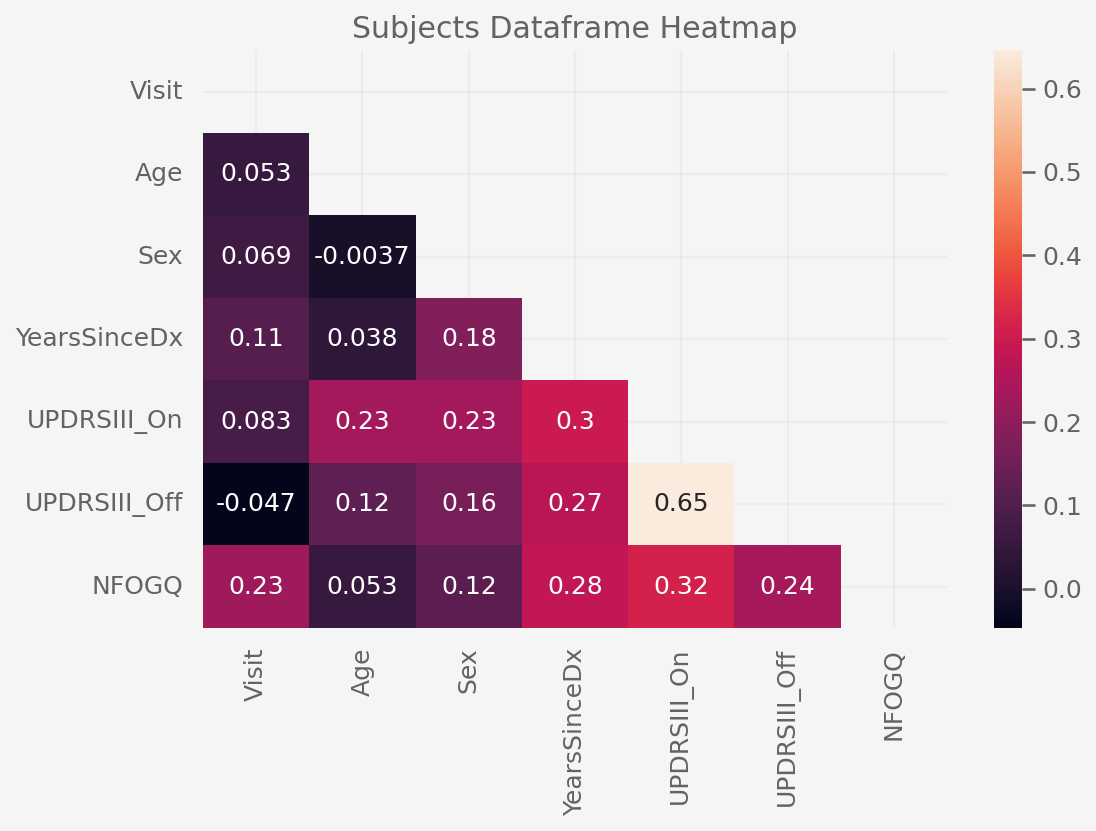

In [218]:
temp = subjects.copy()
temp['Sex'] = temp['Sex'].replace({
    'F': 0,
    'M': 1
})

corr = temp.corr()
mask = np.triu(np.ones_like(corr))

plt.figure(figsize=(8, 5))

sns.heatmap(corr, mask=mask, annot=True).set_title('Subjects Dataframe Heatmap')

plt.show()

### Events

- Metadata for each FoG event in all data series. The event times agree with the labels in the data series.
  - Id The data series the event occured in.
  - Init Time (s) the event began.
  - Completion Time (s) the event ended.
  - Type Whether StartHesitation, Turn, or Walking.
  - Kinetic Whether the event was kinetic (1) and involved movement, or akinetic (0) and static.

In [166]:
events = pd.read_csv(f'{CFG.DATA_PATH}/events.csv')

print(f'\t{gld}Shape of events \t --> \t {red}{events.shape}{res}')
display(stylize_simple(events.head(5), 'events, top 5 rows (hover to magnify)'))
display(stylize_describe(events, dataset_name='events'))

	Shape of events 	 --> 	 (3712, 5)


,Id,Init,Completion,Type,Kinetic
0,003f117e14,8.613120,14.773100,Turn,1.000000
1,009ee11563,11.384700,41.184700,Turn,1.000000
2,009ee11563,54.664700,58.784700,Turn,1.000000
3,011322847a,28.096600,30.296600,Turn,1.000000
4,01d0fe7266,30.318400,31.878400,Turn,1.000000


,count,mean,std,min,25%,50%,75%,max,NaN count
Init,3712,988.179,946.081,1.020,45.019,849.585,1608.286,4425.577,0.000
Completion,3712,995.975,943.655,2.513,55.686,852.576,1611.910,4437.105,0.000
Kinetic,2669,0.812,0.391,0.000,1.000,1.000,1.000,1.000,1043.000


#### Plots

##### Pie Chart

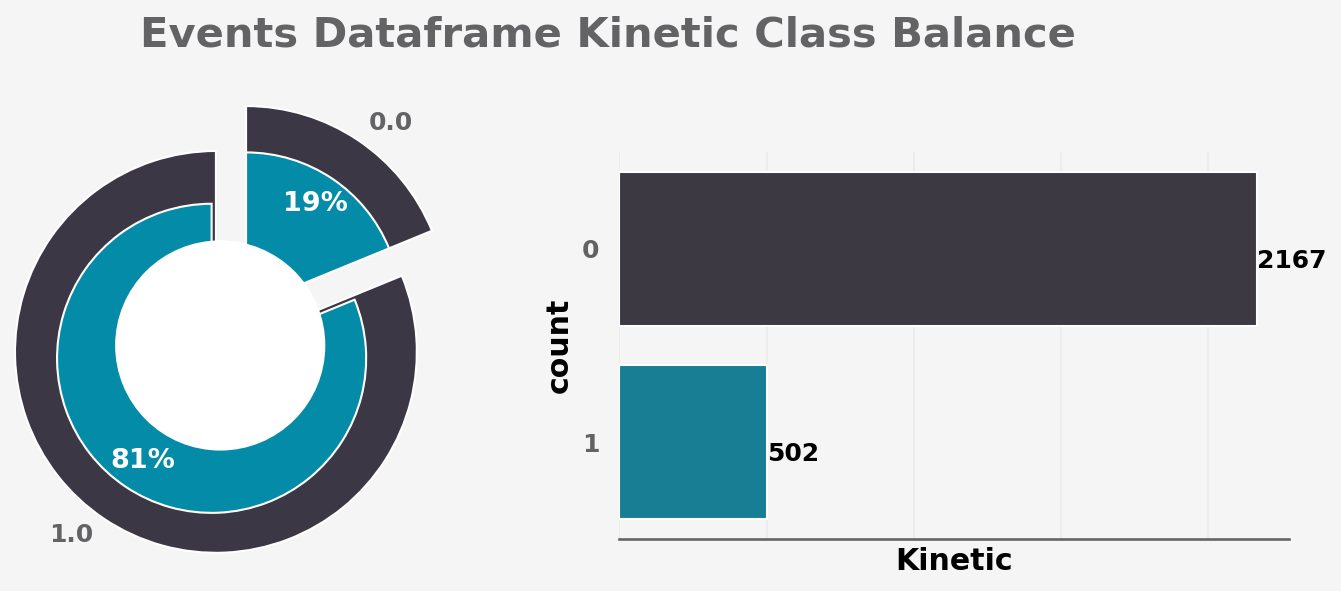

In [216]:
plot_count(events, 'Kinetic', 'Events Dataframe Kinetic Class Balance')

##### Bar Plot

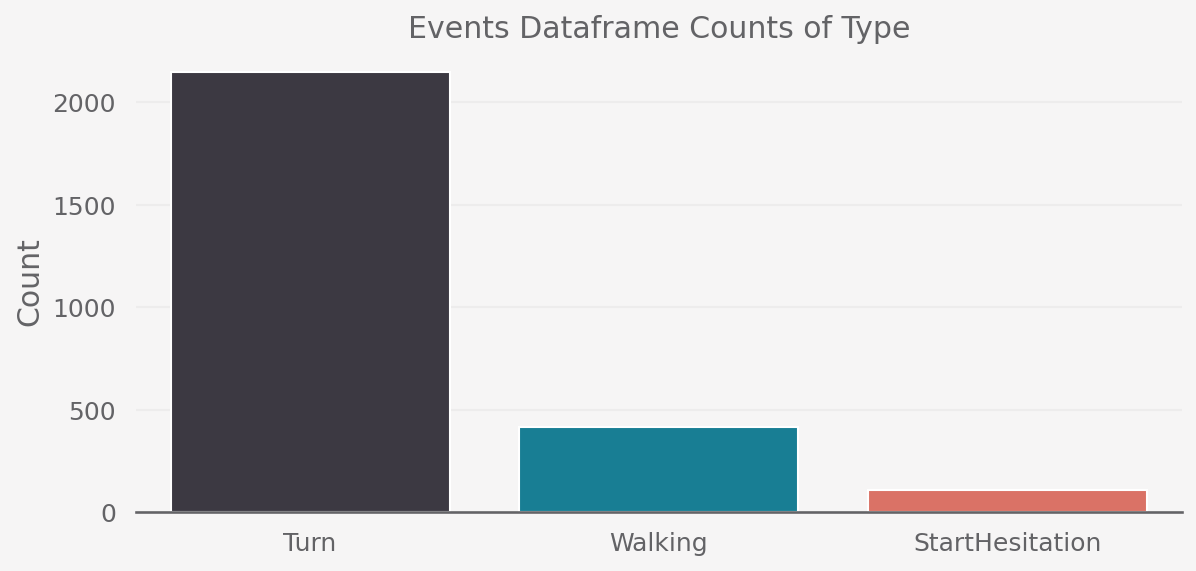

In [215]:
events_type_counts = events['Type'].value_counts()

plt.figure(figsize=(9, 4))

barplot = sns.barplot(x=events_type_counts.index, y=events_type_counts.values)
barplot.set_ylabel('Count')
barplot.set_title('Events Dataframe Counts of Type')
plt.show()

##### Histograms

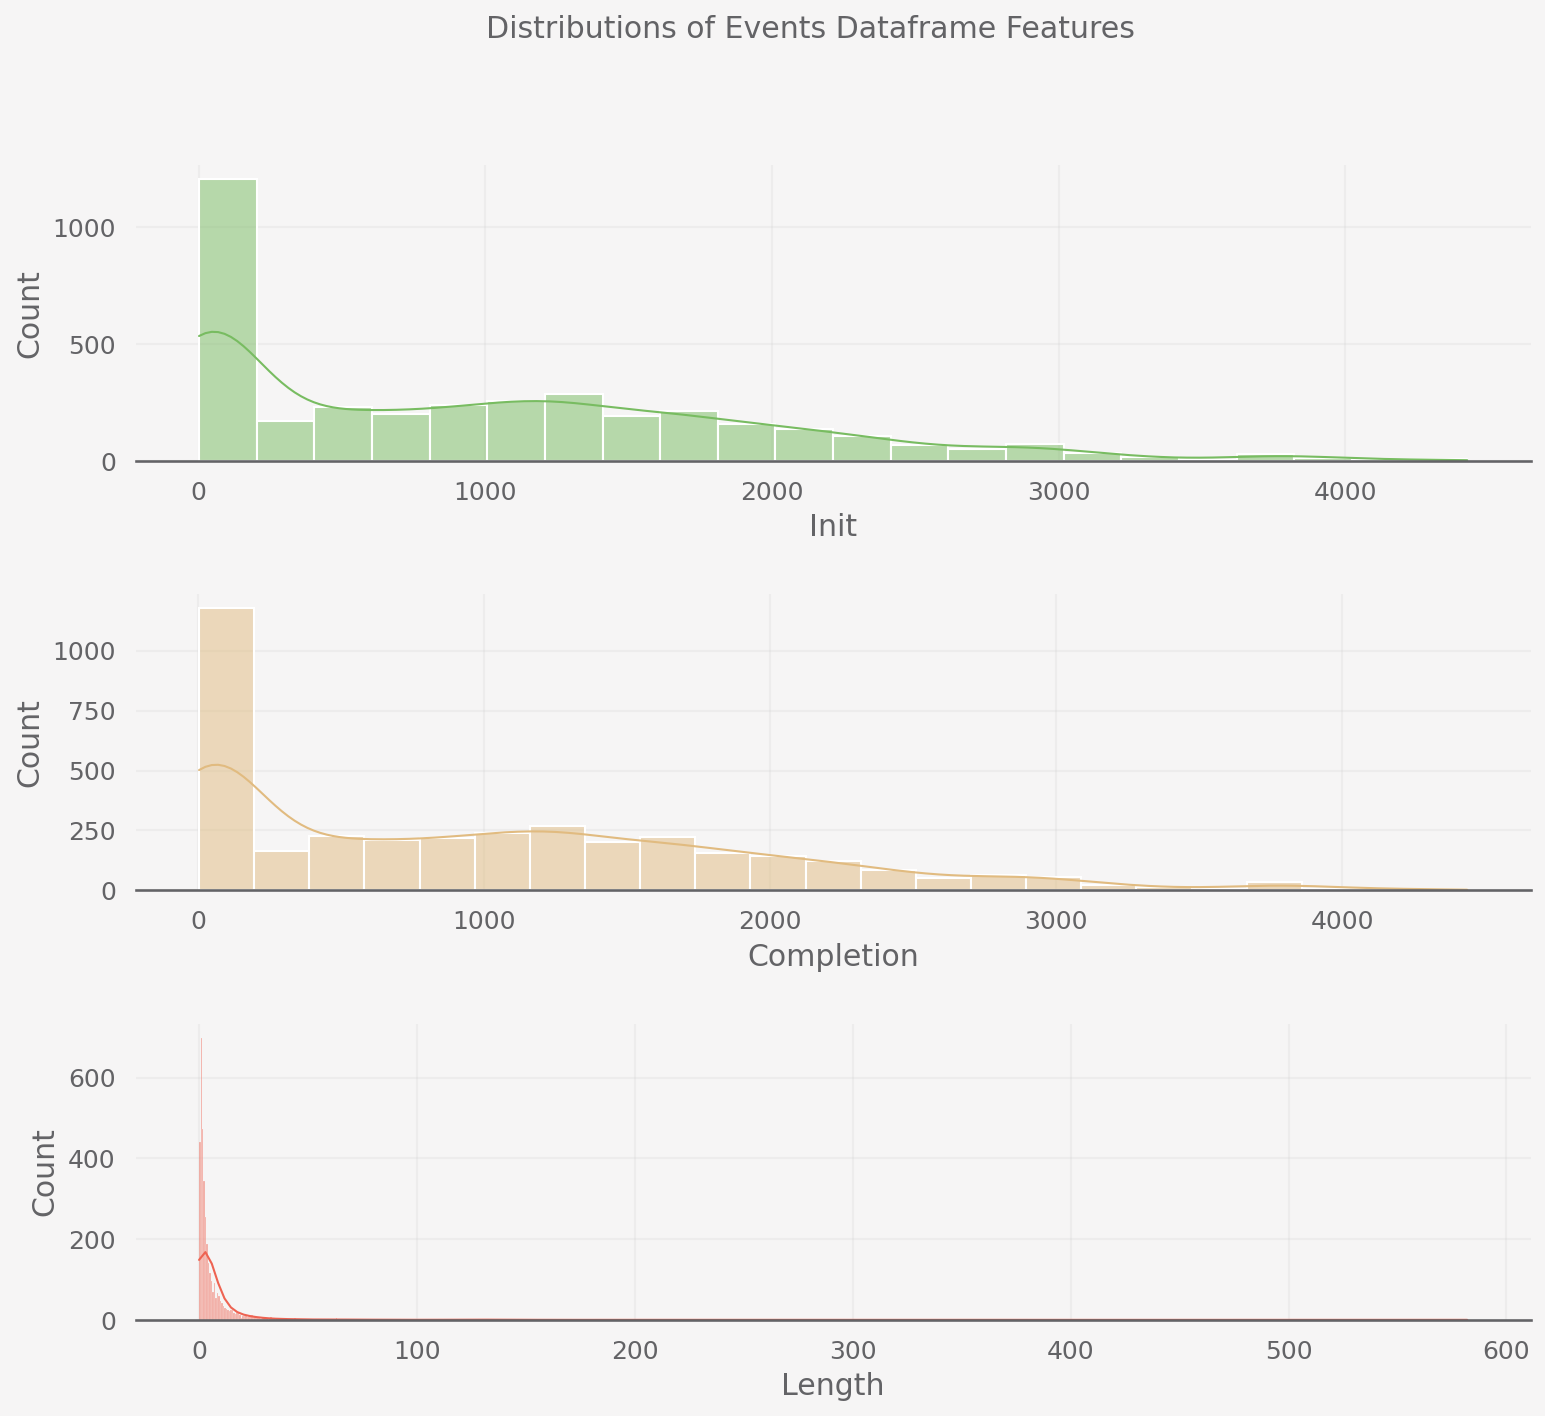

In [214]:
events['Length'] = events['Completion'] - events['Init']
features = ['Init', 'Completion', 'Length']

fig, axes = plt.subplots(3, 1, figsize=(12, 10))

for idx, (ax, col) in enumerate(zip(axes.ravel(), features), start=1):
    sns.histplot(events, x=col, ax=ax, kde=True, color=palette[len(palette)-idx])

plt.subplots_adjust(hspace=0.45)
plt.suptitle('Distributions of Events Dataframe Features')
plt.show()

##### Correlation Matrix

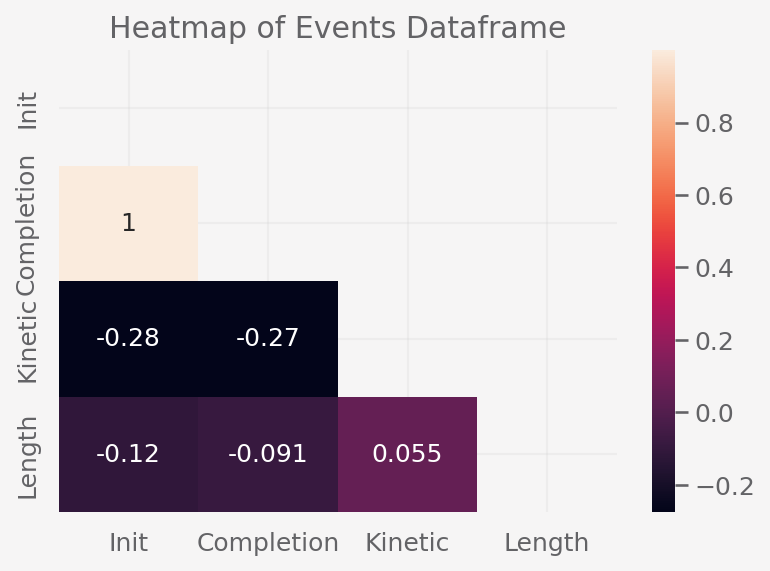

In [213]:
corr = events.corr()
mask = np.triu(np.ones_like(corr))

plt.figure(figsize=(6, 4))

sns.heatmap(corr, mask=mask, annot=True).set_title('Heatmap of Events Dataframe')

plt.show()

### Tasts

- Task metadata for series in the defog dataset. (Not relevant for the series in the fog or daily datasets.)
  - Id The data series where the task was measured.
  - Begin Time (s) the task began.
  - End Time (s) the task ended.
  - Task One of seven tasks types in the DeFOG protocol, described on this page.

In [197]:
tasks = pd.read_csv(f'{CFG.DATA_PATH}/tasks.csv')

print(f'\t{gld}Shape of tasks \t --> \t {red}{tasks.shape}{res}')
display(stylize_simple(tasks.head(5), 'tasks, top 5 rows (hover to magnify)'))
display(stylize_describe(tasks, dataset_name='tasks'))

	Shape of tasks 	 --> 	 (2817, 4)


,Id,Begin,End,Task
0,02ab235146,10.000000,190.480000,Rest1
1,02ab235146,211.240000,271.560000,Rest2
2,02ab235146,505.880000,522.400000,4MW
3,02ab235146,577.960000,594.640000,4MW-C
4,02ab235146,701.320000,715.280000,MB1


,count,mean,std,min,25%,50%,75%,max,NaN count
Begin,2817,864.281,657.882,10.000,341.990,742.466,1230.840,4320.800,0.000
End,2817,891.158,665.440,10.003,360.209,762.440,1260.440,4424.960,0.000


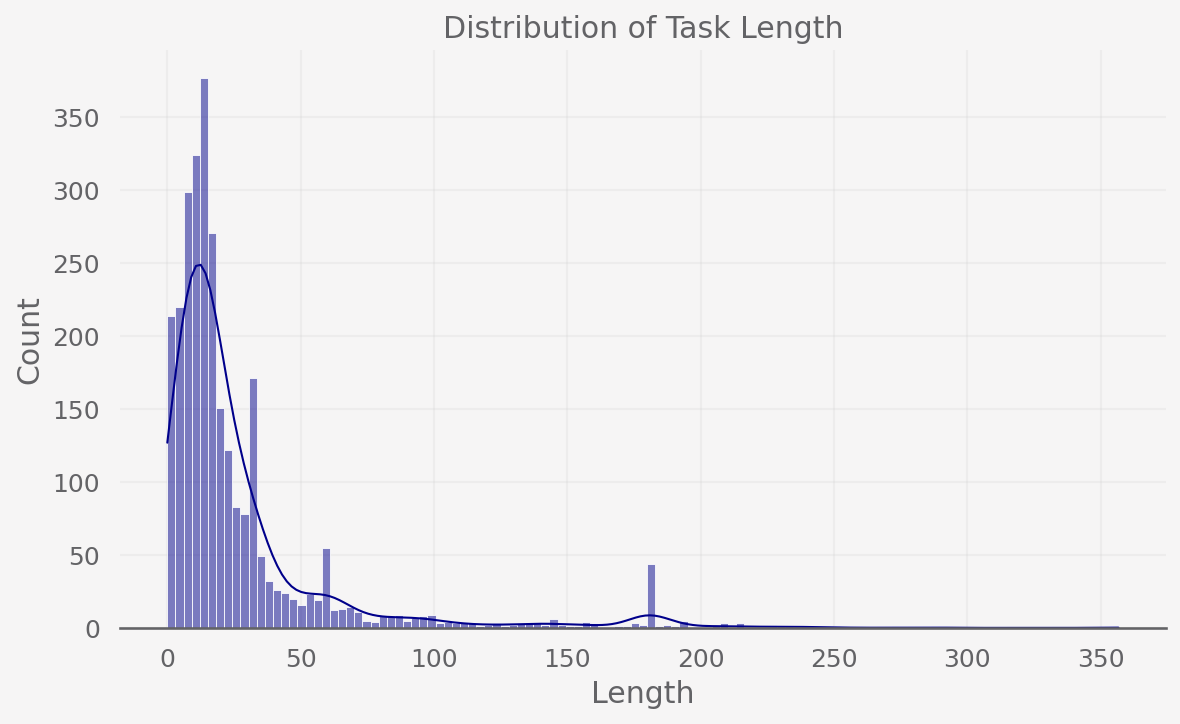

In [211]:
tasks['Length'] = tasks['End'] - tasks['Begin']

plt.figure(figsize=(9, 5))

length = sns.histplot(tasks, x='Length', kde=True, color='darkblue')
length.set_title('Distribution of Task Length')
plt.show()

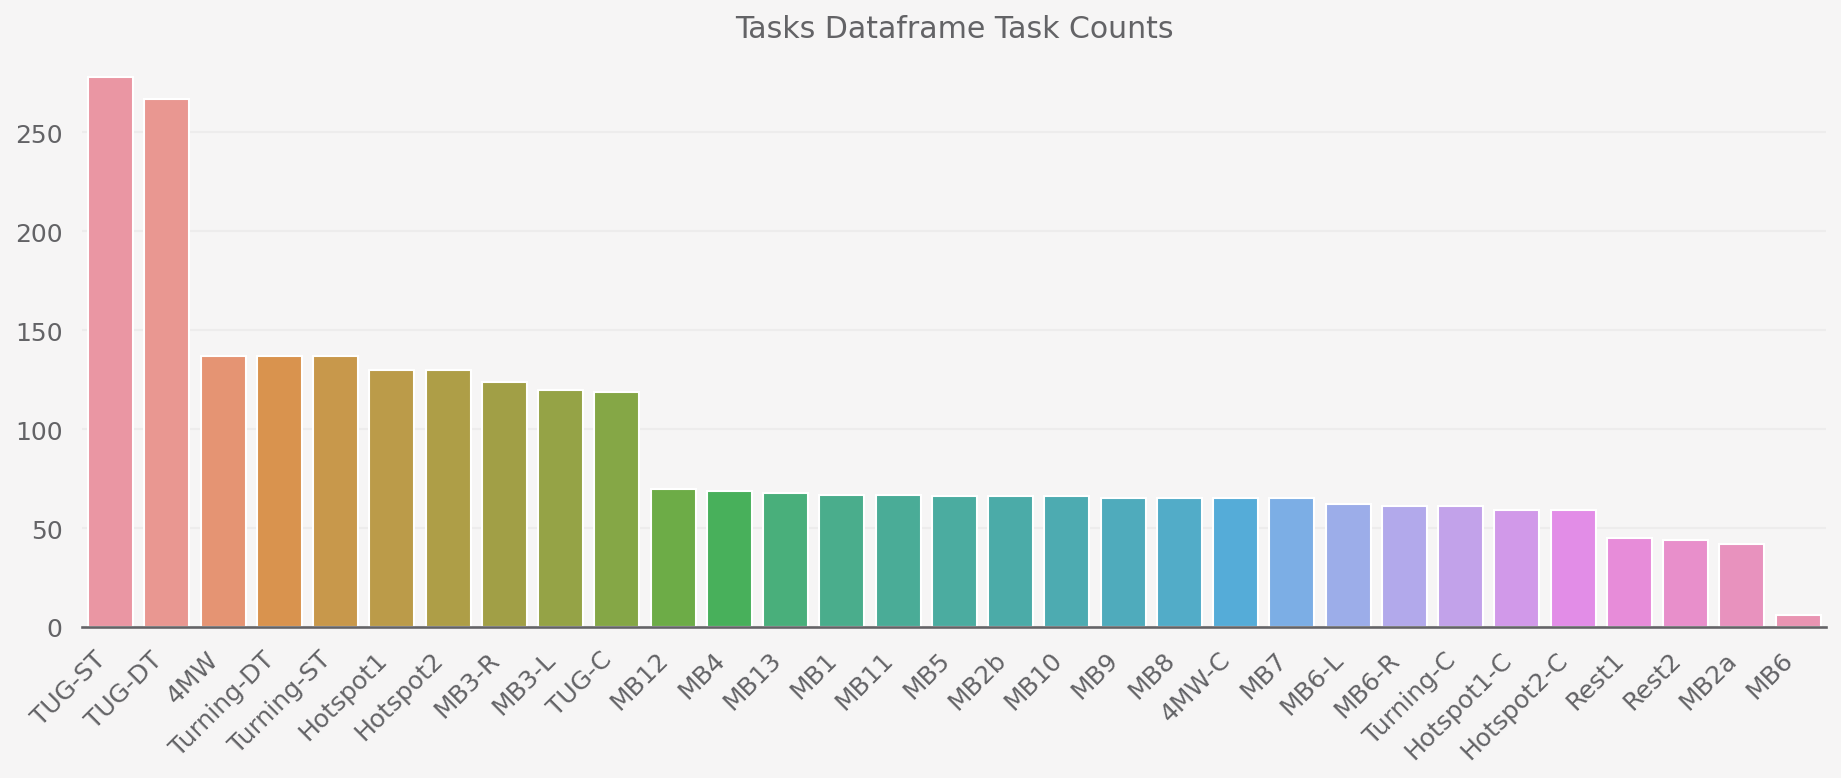

In [210]:
task_counts = tasks['Task'].value_counts()

plt.figure(figsize=(15, 5))

sns.barplot(x=task_counts.index, y=task_counts.values).set_title('Tasks Dataframe Task Counts')
plt.xticks(rotation=45, ha='right')
plt.show()

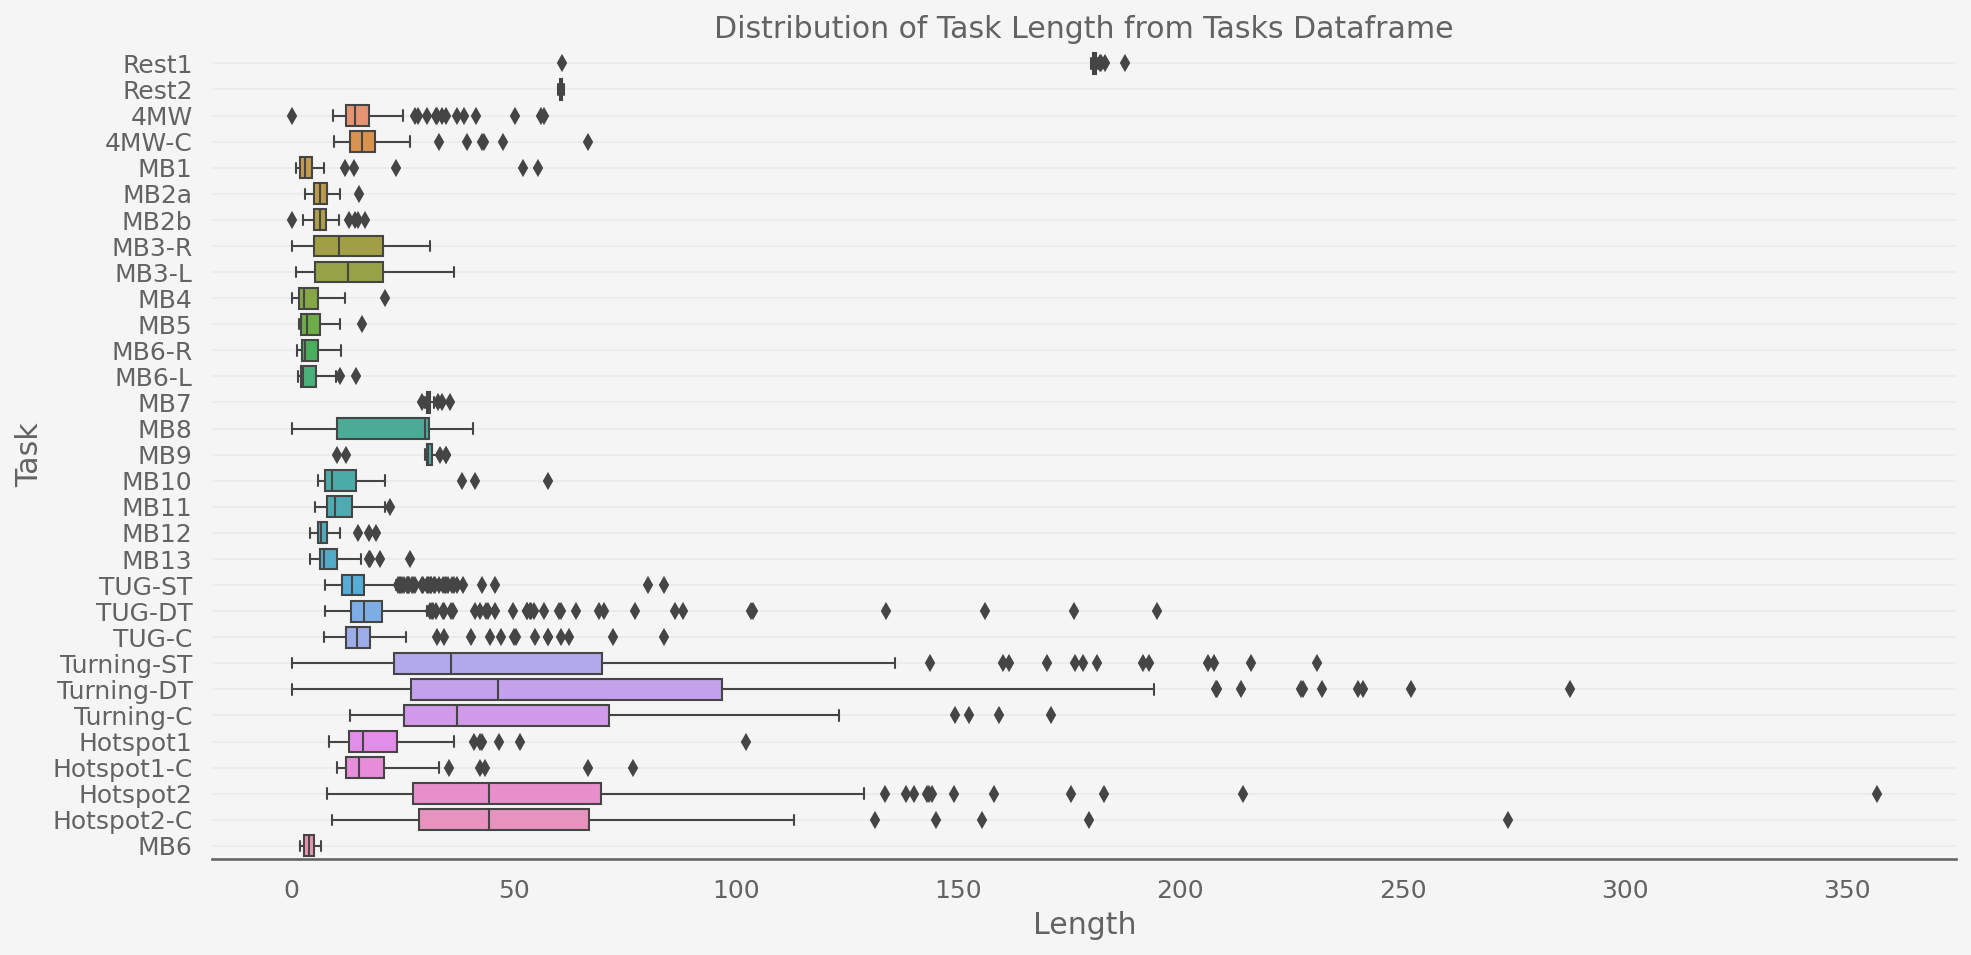

In [254]:
plt.figure(figsize=(15, 7))

boxplot = sns.boxplot(tasks, x='Length', y='Task')
boxplot.set_title('Distribution of Task Length from Tasks Dataframe')

plt.grid()
plt.show()